Processing 2014 (JJAS only)...
Processing 2015 (JJAS only)...
Processing 2016 (JJAS only)...
Processing 2017 (JJAS only)...
Processing 2018 (JJAS only)...
Processing 2019 (JJAS only)...
Processing 2020 (JJAS only)...
Processing 2021 (JJAS only)...
Processing 2022 (JJAS only)...
Processing 2023 (JJAS only)...
Processing 2024 (JJAS only)...


C:\Users\HONOR\AppData\Local\Temp\ipykernel_14632\2789283439.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])


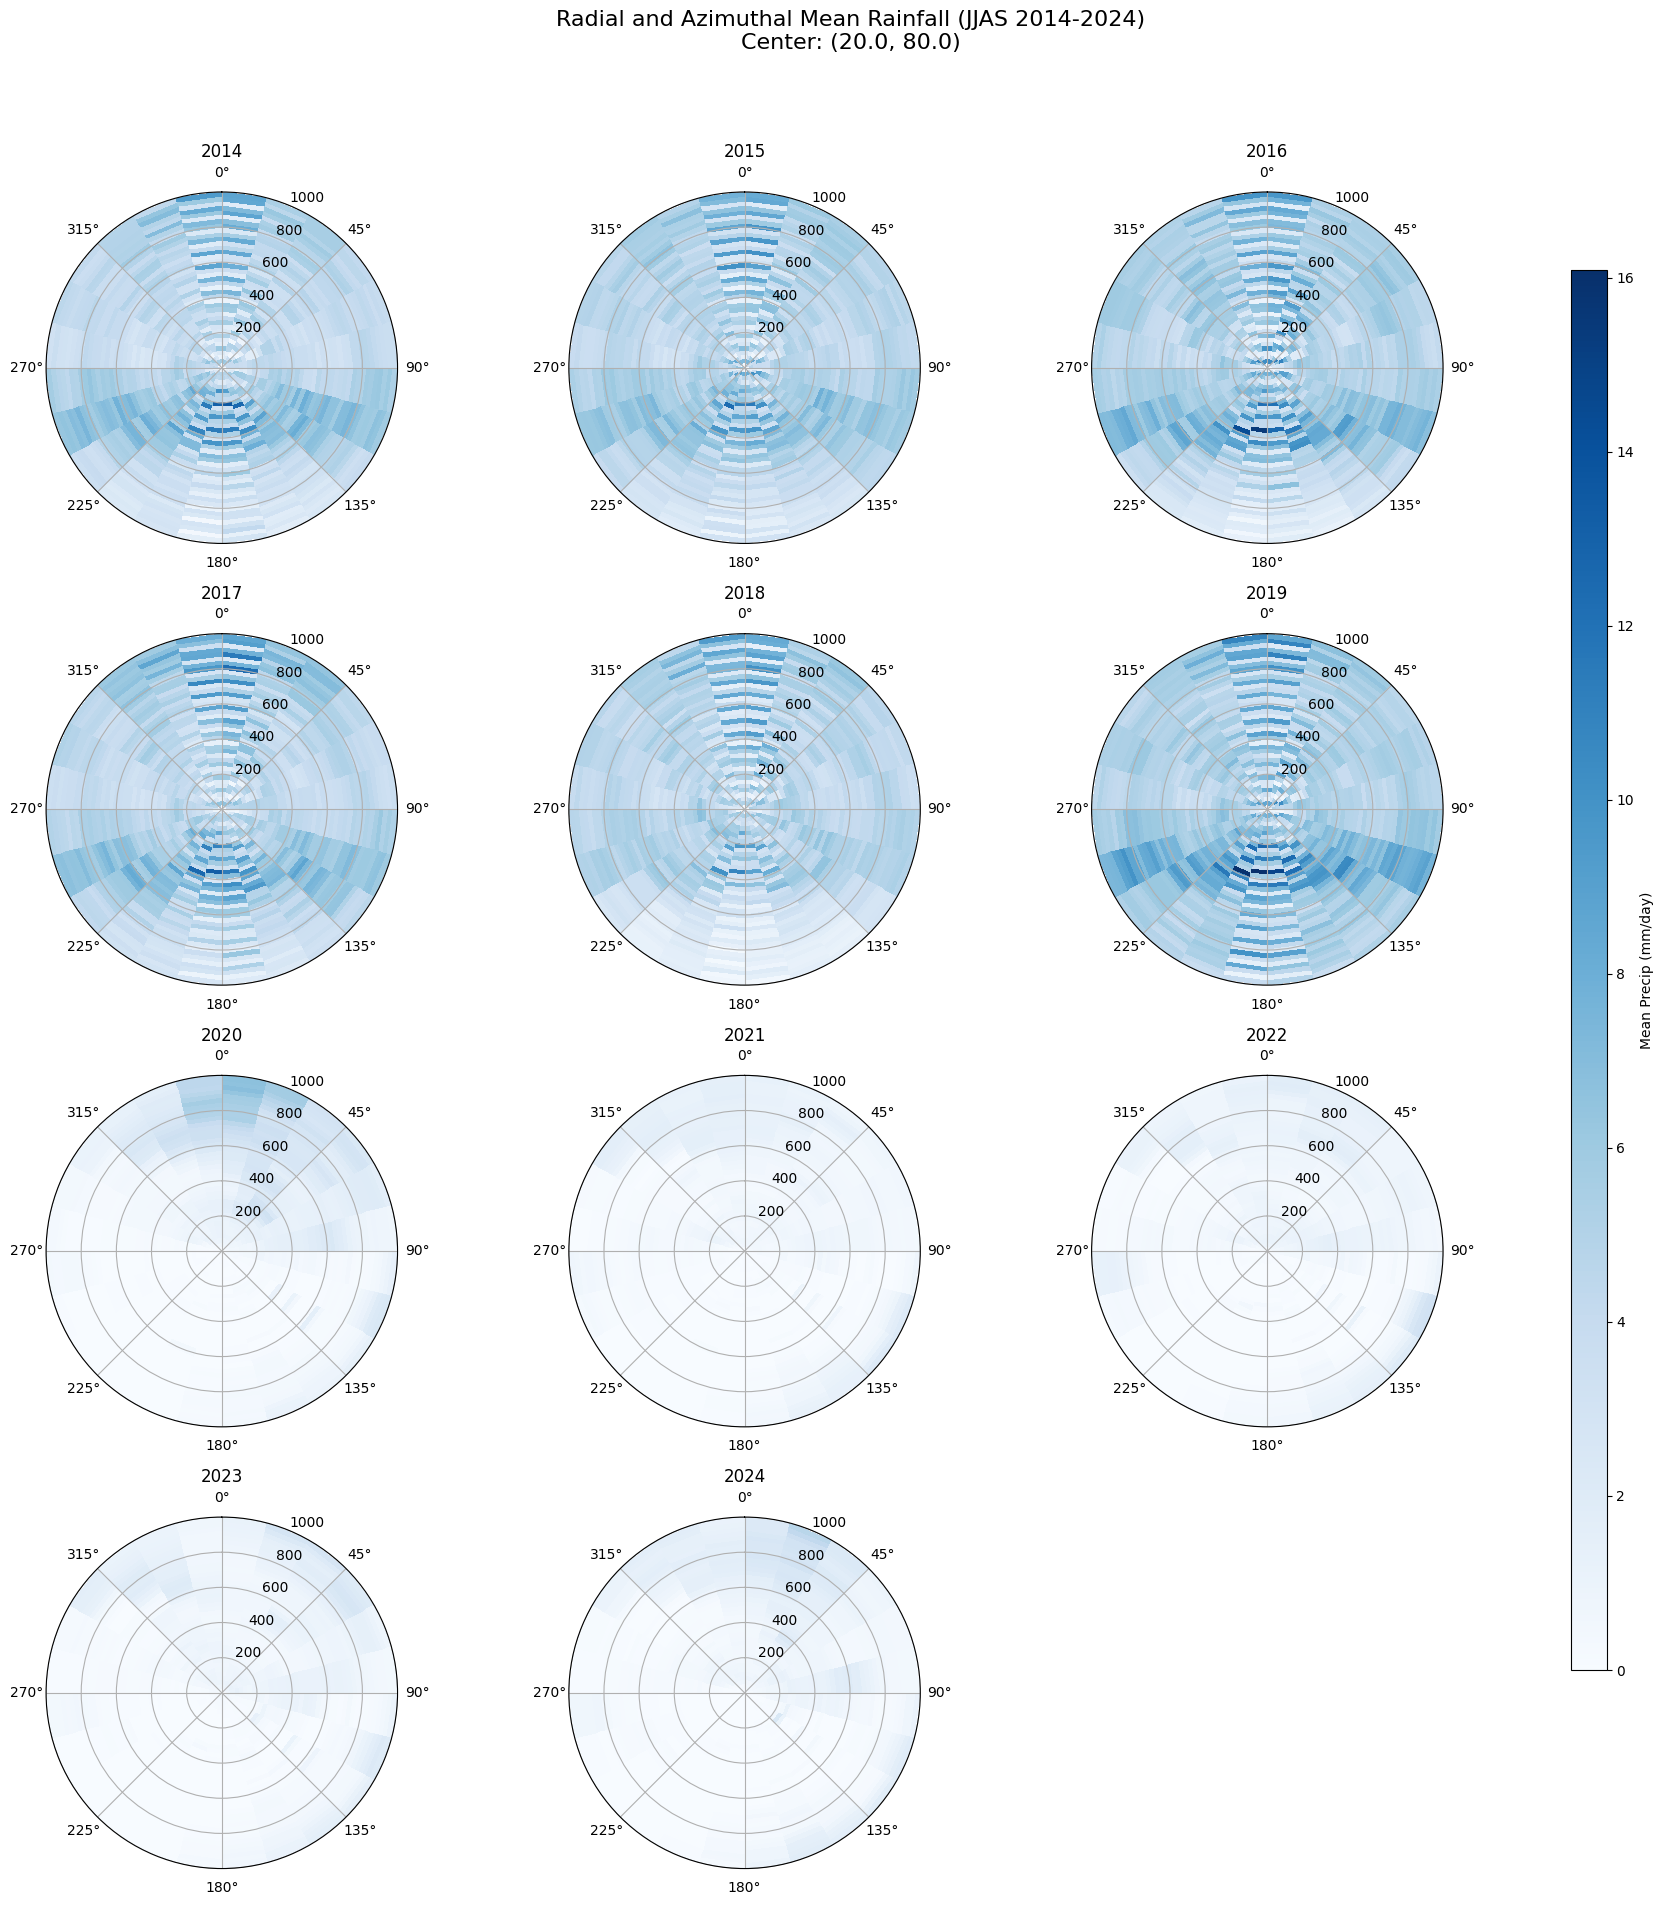

C:\Users\HONOR\AppData\Local\Temp\ipykernel_14632\2789283439.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])


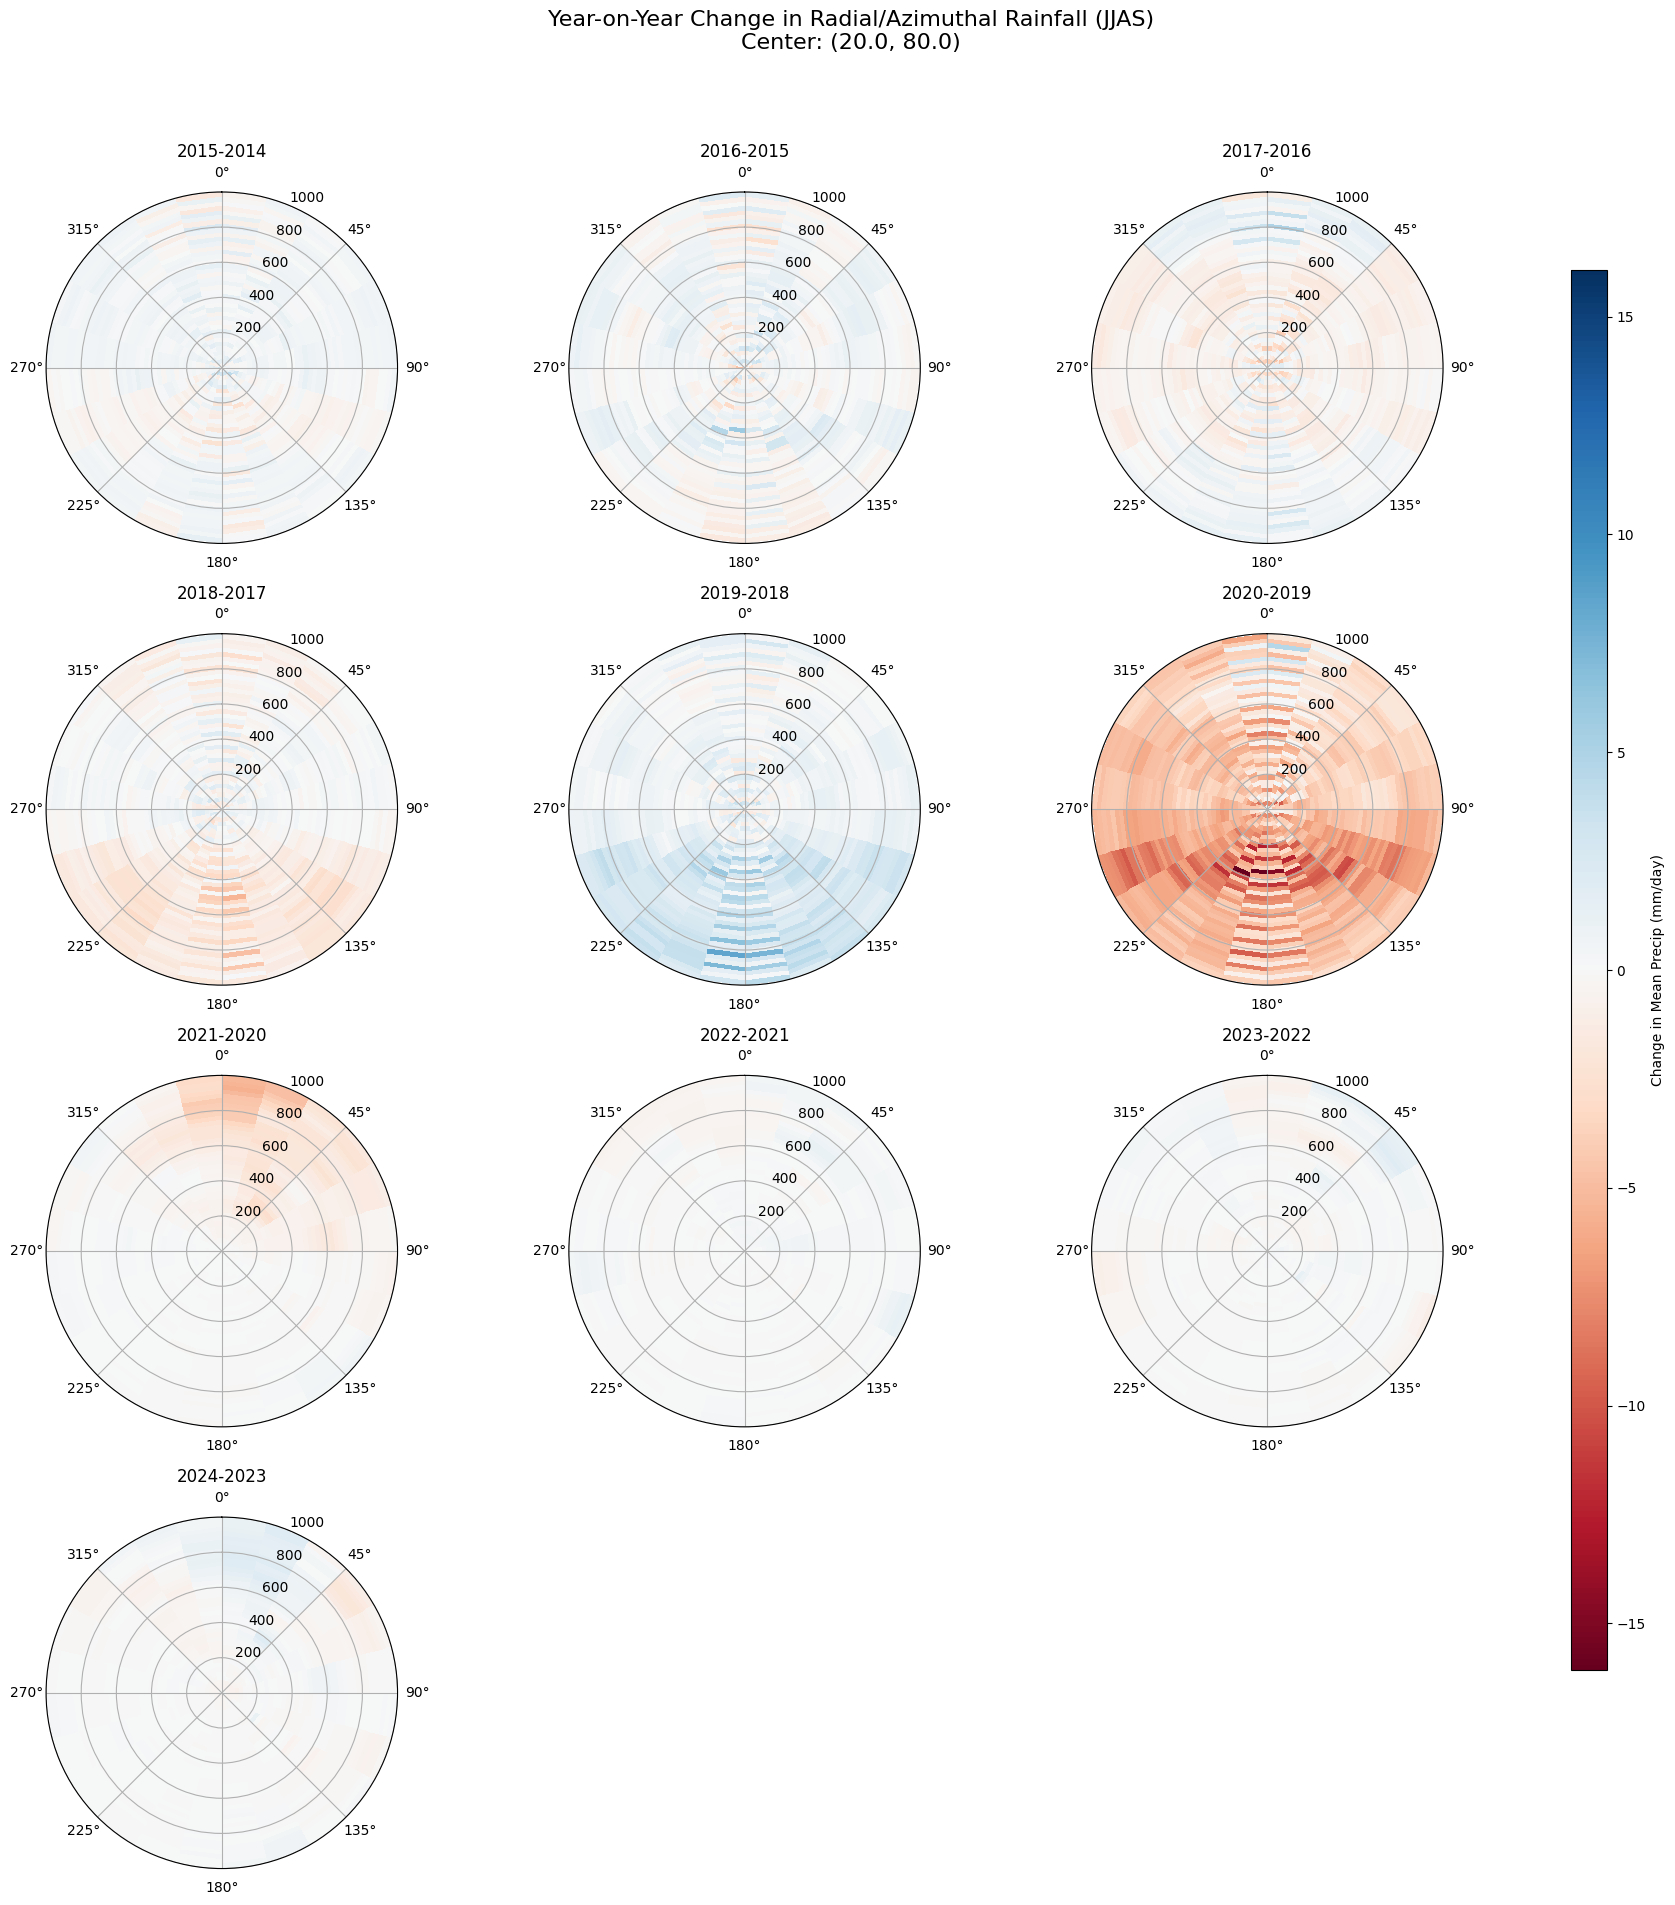

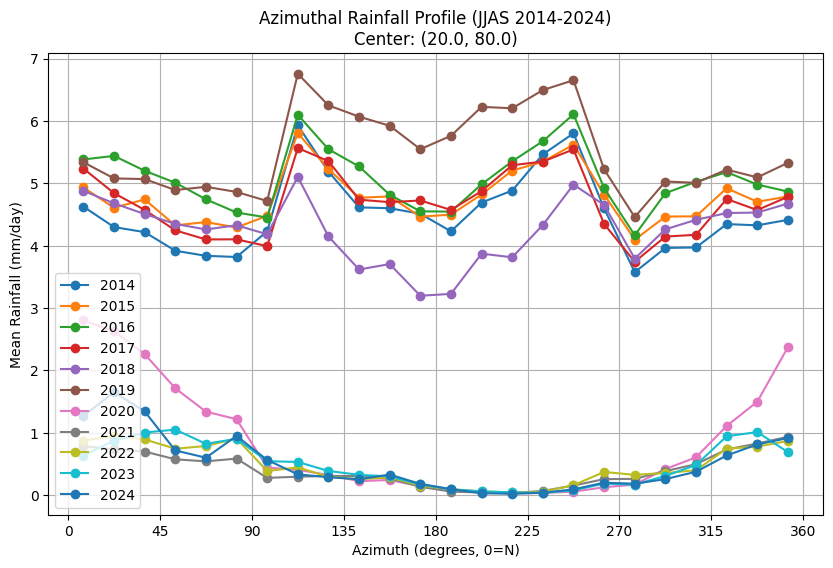

In [1]:
import os
import numpy as np
import h5py
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

years = range(2014, 2025)
lat0, lon0 = 20.0, 80.0

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

def is_jjas(filename):
    """Check if filename corresponds to JJAS month"""
    try:
        date_str = filename.split('.')[4][:8]
        month = int(date_str[4:6])
        return month in [6, 7, 8, 9]
    except Exception:
        return False

radial_bins = np.arange(0, 1000+25, 25)
azimuthal_bins = np.arange(0, 360+15, 15)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

results = {}

for year in years:
    print(f"Processing {year} (JJAS only)...")
    if year < 2020:
        file_path = f'merge_{year}.nc'
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        with xr.open_dataset(file_path) as ds:
            var = 'precipitation' if 'precipitation' in ds else 'precipitationCal'
            # Select only JJAS months
            ds_jjas = ds.sel(time=ds['time'].dt.month.isin([6,7,8,9]))
            if len(ds_jjas['time']) == 0:
                print(f"No JJAS data found for {year}")
                continue
            precip_mean = ds_jjas[var].mean(dim='time').values
            lats = ds['lat'].values
            lons = ds['lon'].values
    else:
        folder_path = f'merge_{year}'
        if not os.path.isdir(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        nc4_files = sorted([
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.nc4') and is_jjas(f)
        ])
        if not nc4_files:
            print(f"No JJAS files found for {year}")
            continue
            
        annual_sum = None
        annual_count = None
        lats, lons = None, None
        for fpath in nc4_files:
            try:
                with h5py.File(fpath, 'r') as f:
                    daily_precip = f['precipitation'][0, :, :].astype(np.float32)
                    if annual_sum is None:
                        annual_sum = np.zeros_like(daily_precip, dtype=np.float64)
                        annual_count = np.zeros_like(daily_precip, dtype=np.uint32)
                        lats = f['lat'][:]
                        lons = f['lon'][:]
                    valid_mask = ~np.isnan(daily_precip)
                    annual_sum[valid_mask] += daily_precip[valid_mask]
                    annual_count[valid_mask] += 1
            except Exception as e:
                print(f"Skipped {os.path.basename(fpath)}: {str(e)[:50]}...")
        if annual_sum is not None and np.any(annual_count > 0):
            precip_mean = np.divide(annual_sum, annual_count, 
                                    out=np.full_like(annual_sum, np.nan), 
                                    where=annual_count>0)
        else:
            print(f"No valid JJAS data for year {year}")
            continue
    
    # Radial/azimuthal binning
    lon2d, lat2d = np.meshgrid(lons, lats)
    R = haversine(lat0, lon0, lat2d, lon2d)
    Theta = azimuth(lat0, lon0, lat2d, lon2d)
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()
    precip_flat = precip_mean.flatten()
    sum_precip, _, _ = np.histogram2d(R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins], weights=precip_flat)
    counts, _, _ = np.histogram2d(R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins])
    mean_precip = np.divide(sum_precip, counts, out=np.zeros_like(sum_precip), where=counts!=0)
    results[year] = mean_precip

# Filter years that have results
valid_years = sorted(results.keys())

# 1. MULTI-PANEL PLOT with SHARED COLORBAR
nplots = len(valid_years)
ncols = 3
nrows = int(np.ceil(nplots / ncols))
fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection':'polar'}, figsize=(18, 5*nrows))
if nplots > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Handle single plot case
vmax = max(np.nanmax(results[y]) for y in valid_years)
vmin = min(np.nanmin(results[y]) for y in valid_years)
pcm_list = []
for idx, year in enumerate(valid_years):
    ax = axes[idx]
    pcm = ax.pcolormesh(theta_centers, r_centers, results[year], shading='auto', cmap='Blues', vmin=vmin, vmax=vmax)
    ax.set_title(str(year))
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    pcm_list.append(pcm)
for idx in range(len(valid_years), len(axes)):
    axes[idx].axis('off')
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(pcm_list[0], cax=cbar_ax, label='Mean Precip (mm/day)')
fig.suptitle(f'Radial and Azimuthal Mean Rainfall (JJAS 2014-2024)\nCenter: ({lat0}, {lon0})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])
plt.show()

# 2. YEAR-ON-YEAR DIFFERENCE (COMPARISON) PLOTS
diff_years = [y for y in range(2015, 2025) if y in results and (y-1) in results]
nplots = len(diff_years)
ncols = 3
nrows = int(np.ceil(nplots / ncols))
if nplots > 0:
    fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection':'polar'}, figsize=(18, 5*nrows))
    axes = axes.flatten() if nplots > 1 else [axes]
    vmax_diff = max(np.nanmax(np.abs(results[yr]-results[yr-1])) for yr in diff_years)
    for idx, year in enumerate(diff_years):
        ax = axes[idx]
        diff = results[year] - results[year-1]
        pcm = ax.pcolormesh(theta_centers, r_centers, diff, shading='auto', cmap='RdBu', vmin=-vmax_diff, vmax=vmax_diff)
        ax.set_title(f'{year}-{year-1}')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
    for idx in range(len(diff_years), len(axes)):
        axes[idx].axis('off')
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(pcm, cax=cbar_ax, label='Change in Mean Precip (mm/day)')
    fig.suptitle(f'Year-on-Year Change in Radial/Azimuthal Rainfall (JJAS)\nCenter: ({lat0}, {lon0})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])
    plt.show()

# 3. RAINFALL VS AZIMUTH (DIRECTION) LINE PLOT
plt.figure(figsize=(10,6))
for year in valid_years:
    azimuthal_profile = results[year].mean(axis=0)
    degrees = (azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2
    plt.plot(degrees, azimuthal_profile, marker='o', label=str(year))
plt.xlabel('Azimuth (degrees, 0=N)')
plt.ylabel('Mean Rainfall (mm/day)')
plt.title(f'Azimuthal Rainfall Profile (JJAS 2014-2024)\nCenter: ({lat0}, {lon0})')
plt.xticks(np.arange(0, 361, 45))
plt.grid(True)
plt.legend()
plt.show()


Processing 2014 (JJAS, Indian subcontinent)...
Processing 2015 (JJAS, Indian subcontinent)...
Processing 2016 (JJAS, Indian subcontinent)...
Processing 2017 (JJAS, Indian subcontinent)...
Processing 2018 (JJAS, Indian subcontinent)...
Processing 2019 (JJAS, Indian subcontinent)...
Processing 2020 (JJAS, Indian subcontinent)...
Processing 2021 (JJAS, Indian subcontinent)...
Processing 2022 (JJAS, Indian subcontinent)...
Processing 2023 (JJAS, Indian subcontinent)...
Processing 2024 (JJAS, Indian subcontinent)...


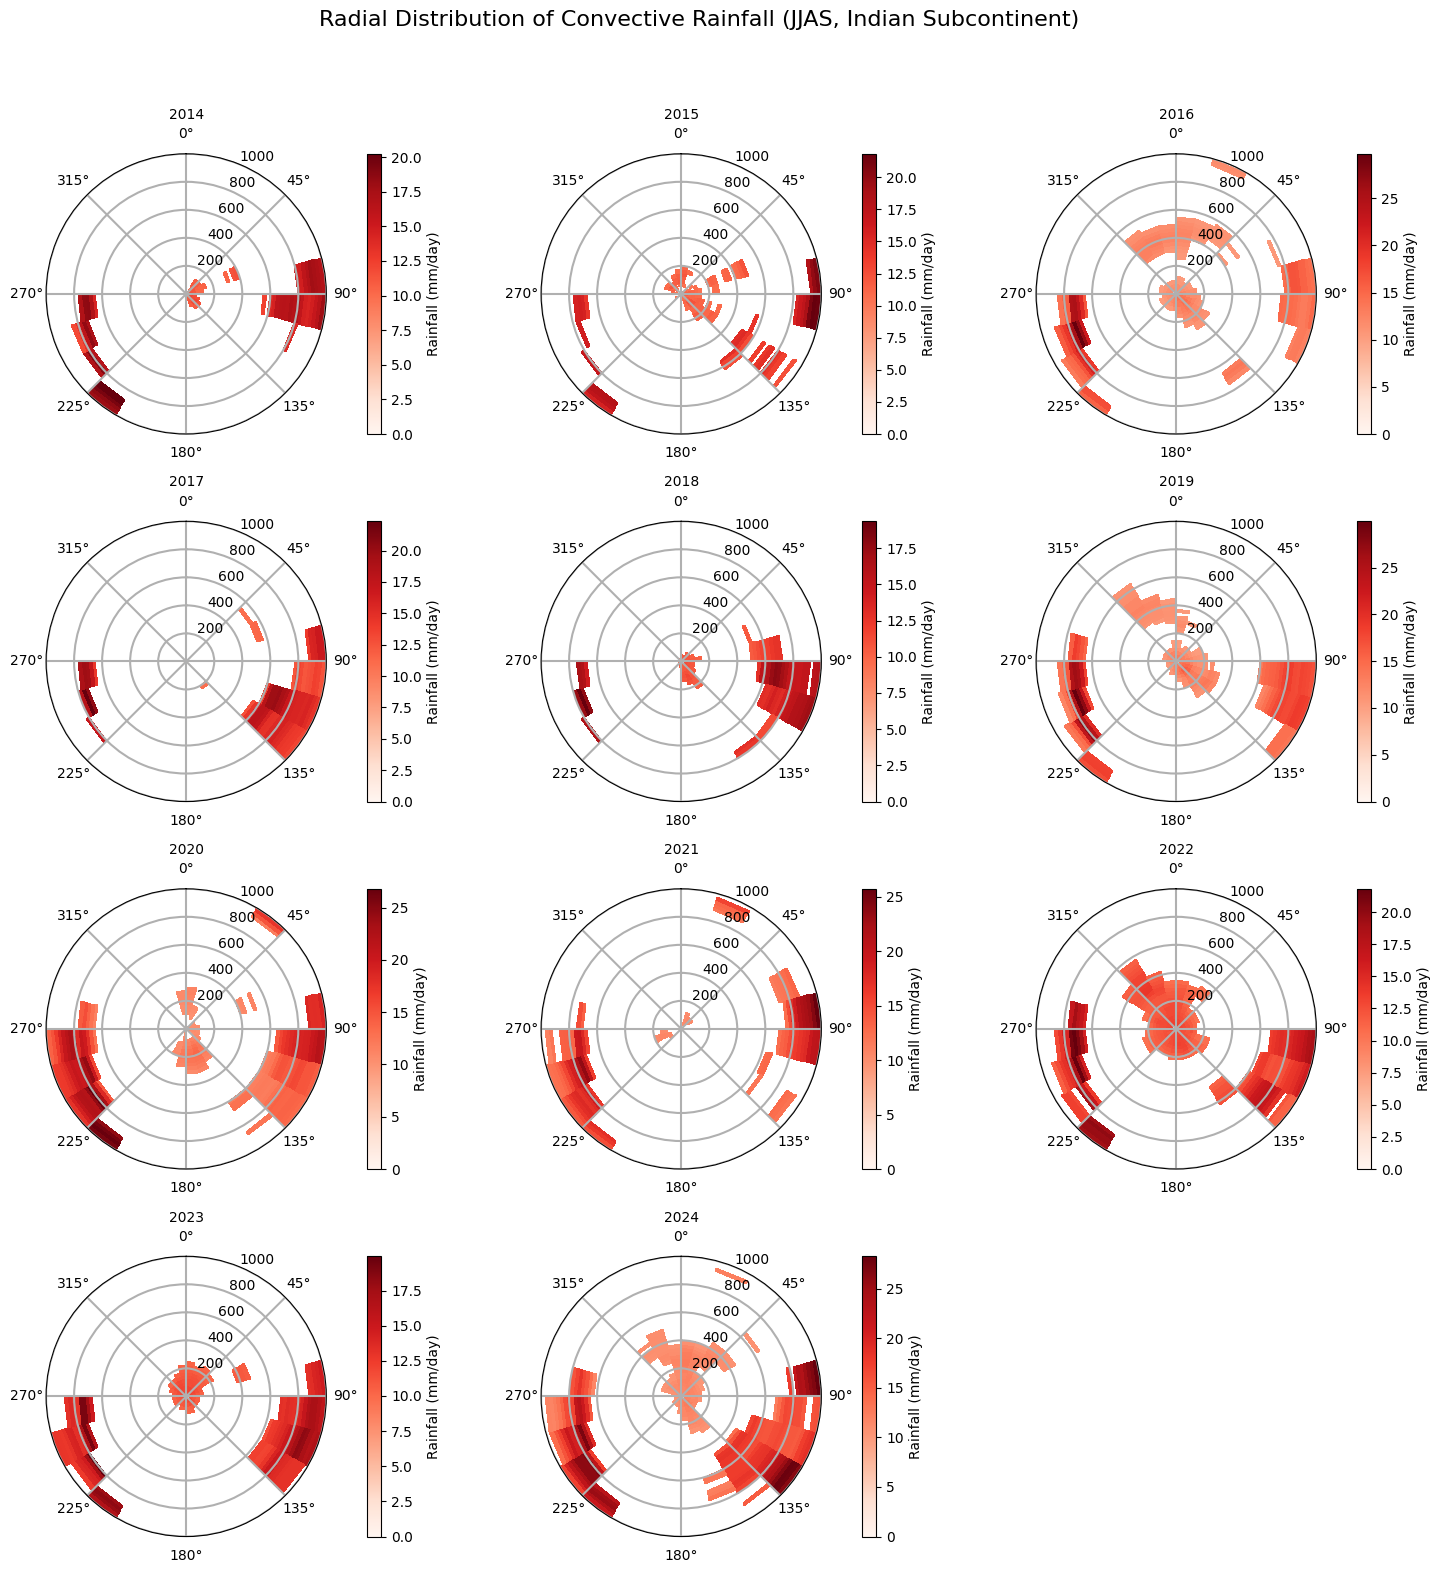

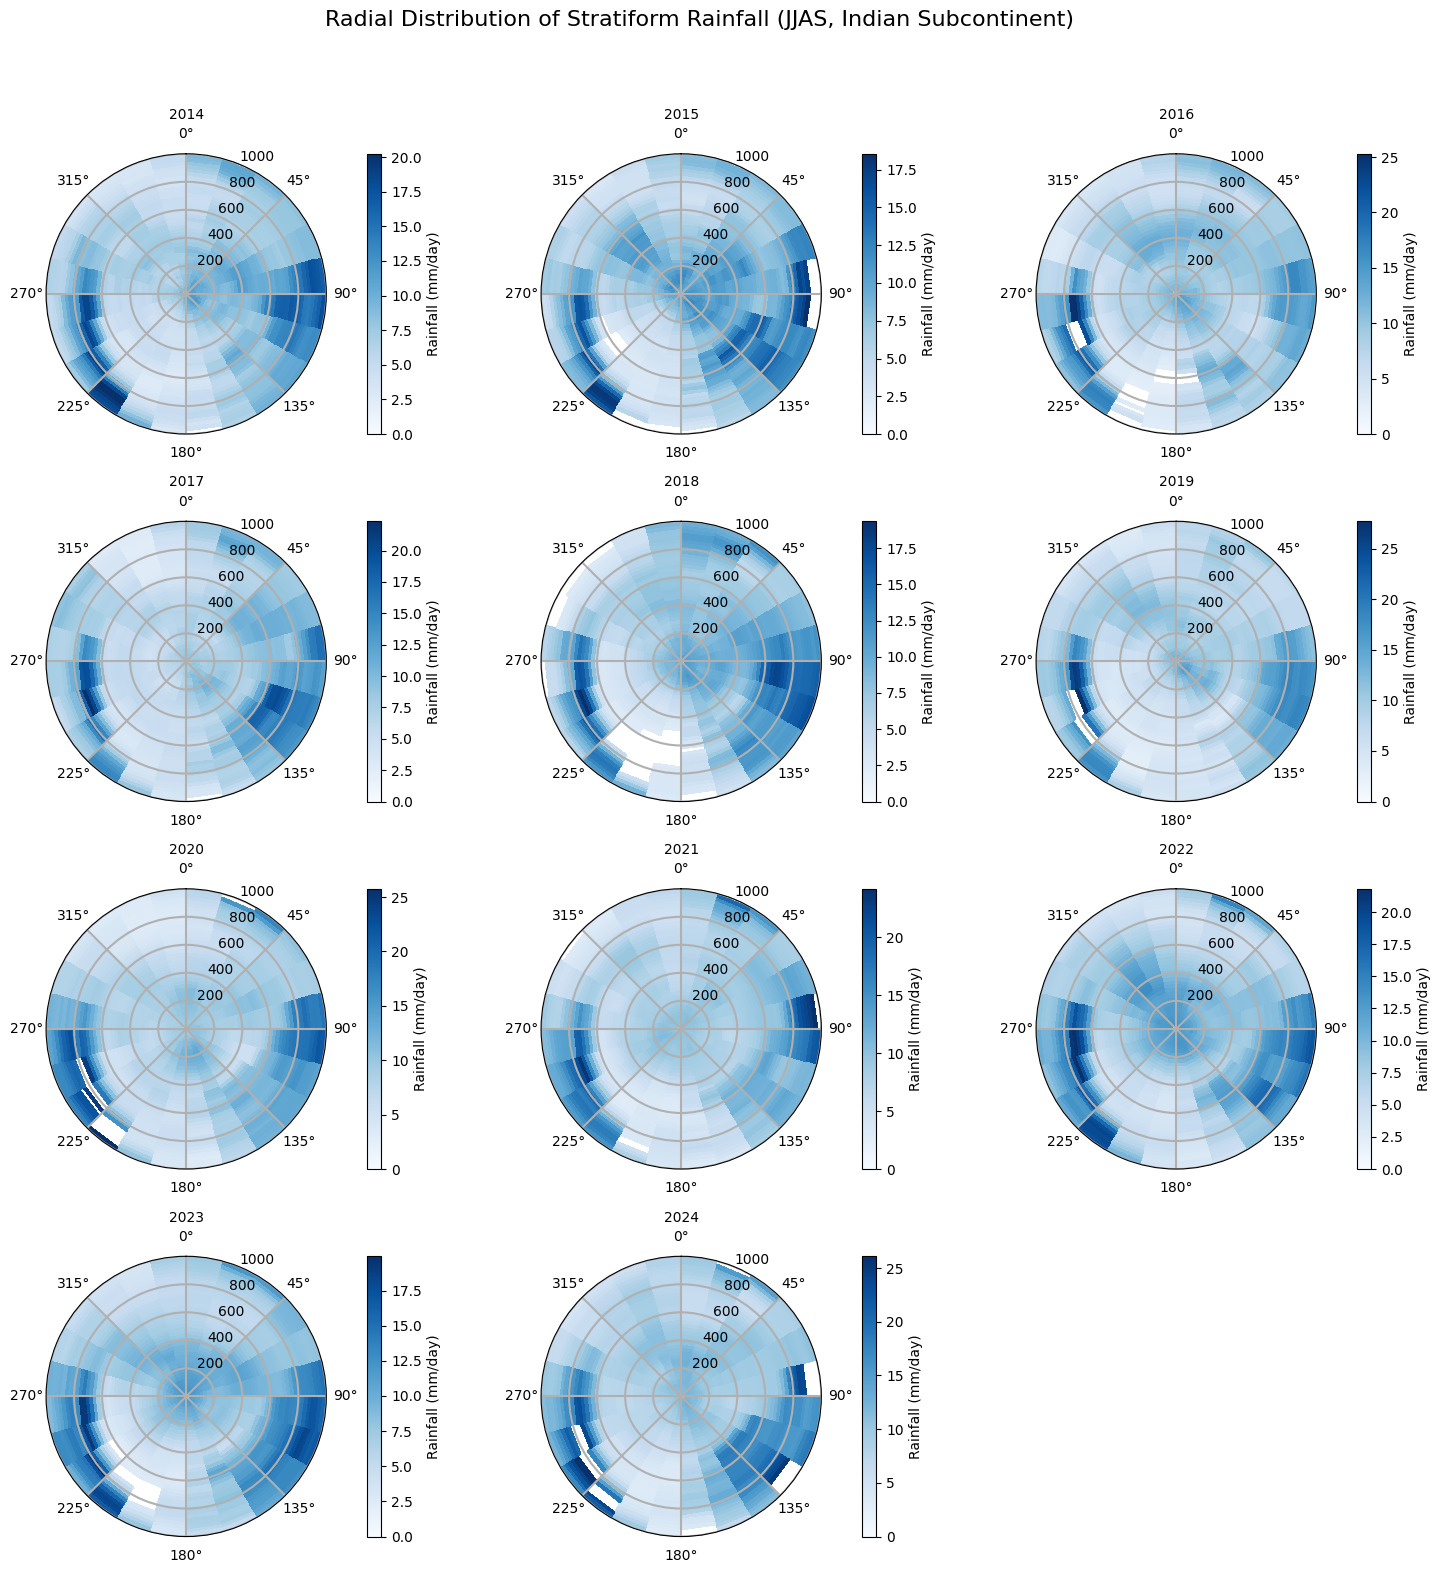

C:\Users\HONOR\AppData\Local\Temp\ipykernel_14632\646598762.py:183: RuntimeWarning: Mean of empty slice
  azimuthal_profile = np.nanmean(results[year], axis=0)


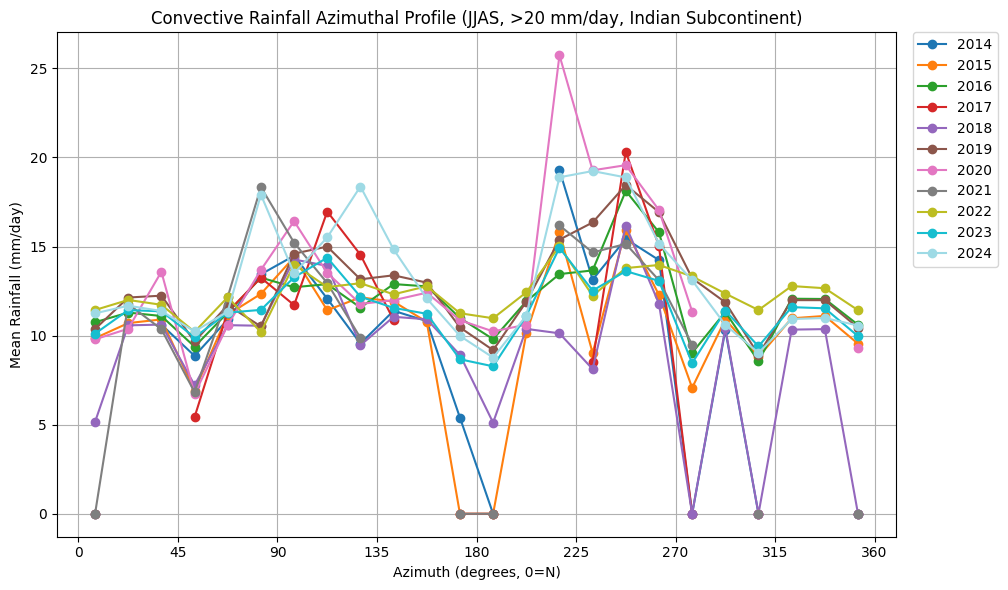

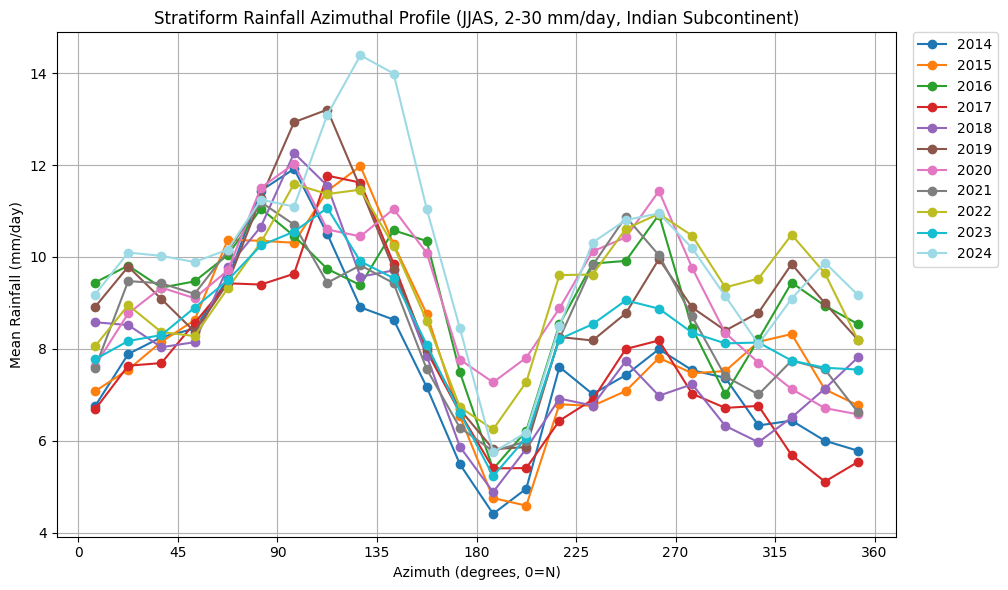

In [2]:
import os
import numpy as np
import h5py
import xarray as xr
import matplotlib.pyplot as plt

years = range(2014, 2025)
lat0, lon0 = 20.0, 80.0  # Center for radial/azimuthal calculation

convective_threshold = 10.0  # mm/day, for daily means
stratiform_lower = 2.0
stratiform_upper = 30.0

radial_bins = np.arange(0, 1000+25, 25)
azimuthal_bins = np.arange(0, 360+15, 15)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

def is_jjas(filename):
    try:
        date_str = filename.split('.')[4][:8]
        month = int(date_str[4:6])
        return month in [6, 7, 8, 9]
    except Exception:
        return False

def restrict_india(precip, lats, lons):
    lat_mask = (lats >= 5) & (lats <= 37)
    lon_mask = (lons >= 66) & (lons <= 98)
    if precip.shape[0] == len(lats) and precip.shape[1] == len(lons):
        precip_sub = precip[lat_mask, :][:, lon_mask]
    elif precip.shape[1] == len(lats) and precip.shape[0] == len(lons):
        precip = precip.T
        precip_sub = precip[lat_mask, :][:, lon_mask]
    else:
        raise ValueError("Cannot determine array order for subsetting")
    lats_sub = lats[lat_mask]
    lons_sub = lons[lon_mask]
    return precip_sub, lats_sub, lons_sub

def compute_radial_azimuthal(precip, lats, lons):
    lon2d, lat2d = np.meshgrid(lons, lats)
    R = haversine(lat0, lon0, lat2d, lon2d)
    Theta = azimuth(lat0, lon0, lat2d, lon2d)
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()
    precip_flat = precip.flatten()
    sum_precip, _, _ = np.histogram2d(
        R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins], weights=precip_flat
    )
    counts, _, _ = np.histogram2d(
        R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins]
    )
    return np.divide(sum_precip, counts, out=np.zeros_like(sum_precip), where=counts != 0)

convective_results = {}
stratiform_results = {}

for year in years:
    print(f"Processing {year} (JJAS, Indian subcontinent)...")
    if year < 2020:
        file_path = f'merge_{year}.nc'
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        with xr.open_dataset(file_path) as ds:
            var = 'precipitation' if 'precipitation' in ds else 'precipitationCal'
            ds_jjas = ds.sel(time=ds['time'].dt.month.isin([6,7,8,9]))
            if len(ds_jjas['time']) == 0:
                print(f"No JJAS data found for {year}")
                continue
            precip = ds_jjas[var].mean(dim='time').values
            lats = ds['lat'].values
            lons = ds['lon'].values
    else:
        folder_path = f'merge_{year}'
        if not os.path.isdir(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        nc4_files = sorted([
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.nc4') and is_jjas(f)
        ])
        if not nc4_files:
            print(f"No JJAS files found for {year}")
            continue
        annual_sum = None
        annual_count = None
        lats, lons = None, None
        for fpath in nc4_files:
            try:
                with h5py.File(fpath, 'r') as f:
                    daily_precip = f['precipitation'][0, :, :].astype(np.float32)
                    if annual_sum is None:
                        annual_sum = np.zeros_like(daily_precip, dtype=np.float64)
                        annual_count = np.zeros_like(daily_precip, dtype=np.uint32)
                        lats = f['lat'][:]
                        lons = f['lon'][:]
                    valid_mask = ~np.isnan(daily_precip)
                    annual_sum[valid_mask] += daily_precip[valid_mask]
                    annual_count[valid_mask] += 1
            except Exception as e:
                print(f"Skipped {os.path.basename(fpath)}: {str(e)[:50]}...")
        if annual_sum is not None and np.any(annual_count > 0):
            precip = np.divide(annual_sum, annual_count, 
                               out=np.full_like(annual_sum, np.nan), 
                               where=annual_count>0)
        else:
            print(f"No valid JJAS data for year {year}")
            continue

    # Restrict to Indian subcontinent
    try:
        precip_sub, lats_sub, lons_sub = restrict_india(precip, lats, lons)
    except Exception as e:
        print(f"Error restricting to India: {e}")
        continue

    # Mask for convective
    conv_mask = precip_sub > convective_threshold
    convective = np.where(conv_mask, precip_sub, np.nan)
    convective_results[year] = compute_radial_azimuthal(convective, lats_sub, lons_sub)

    # Mask for stratiform
    strat_mask = (precip_sub >= stratiform_lower) & (precip_sub <= stratiform_upper)
    stratiform = np.where(strat_mask, precip_sub, np.nan)
    stratiform_results[year] = compute_radial_azimuthal(stratiform, lats_sub, lons_sub)

# --- Polar plots with per-panel colorbars ---
def plot_radial_distribution_per_panel(results, title, cmap='Reds'):
    valid_years = sorted(results.keys())
    n_years = len(valid_years)
    ncols = 3
    nrows = (n_years + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection': 'polar'}, figsize=(15, 4*nrows))
    axes = axes.flatten() if nrows > 1 else [axes]
    for idx, year in enumerate(valid_years):
        ax = axes[idx]
        data = results[year]
        if np.all(np.isnan(data)):
            ax.set_title(f'{year}\nNo Data', fontsize=10)
            ax.axis('off')
            continue
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        pcm = ax.pcolormesh(theta_centers, r_centers, data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f'{year}', fontsize=10)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        fig.colorbar(pcm, ax=ax, pad=0.1, fraction=0.05, label='Rainfall (mm/day)')
        ax.grid(linewidth=1.5)
    for idx in range(n_years, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Azimuthal profile plot with colorful lines and legend outside ---
def plot_azimuthal_profiles(results, title):
    plt.figure(figsize=(12, 6))
    degrees = (azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2
    valid_years = sorted(results.keys())
    cmap = plt.get_cmap('tab20', len(valid_years))
    for i, year in enumerate(valid_years):
        azimuthal_profile = np.nanmean(results[year], axis=0)
        plt.plot(degrees, azimuthal_profile, marker='o', label=str(year), color=cmap(i))
    plt.xlabel('Azimuth (degrees, 0=N)')
    plt.ylabel('Mean Rainfall (mm/day)')
    plt.title(title)
    plt.xticks(np.arange(0, 361, 45))
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# --- Plot all ---
plot_radial_distribution_per_panel(
    convective_results,
    'Radial Distribution of Convective Rainfall (JJAS, Indian Subcontinent)',
    cmap='Reds'
)
plot_radial_distribution_per_panel(
    stratiform_results,
    'Radial Distribution of Stratiform Rainfall (JJAS, Indian Subcontinent)',
    cmap='Blues'
)
plot_azimuthal_profiles(
    convective_results,
    'Convective Rainfall Azimuthal Profile (JJAS, >20 mm/day, Indian Subcontinent)'
)
plot_azimuthal_profiles(
    stratiform_results,
    'Stratiform Rainfall Azimuthal Profile (JJAS, 2-30 mm/day, Indian Subcontinent)'
)


Creating synthetic data for demonstration...
Computing frequency-wavenumber spectra...


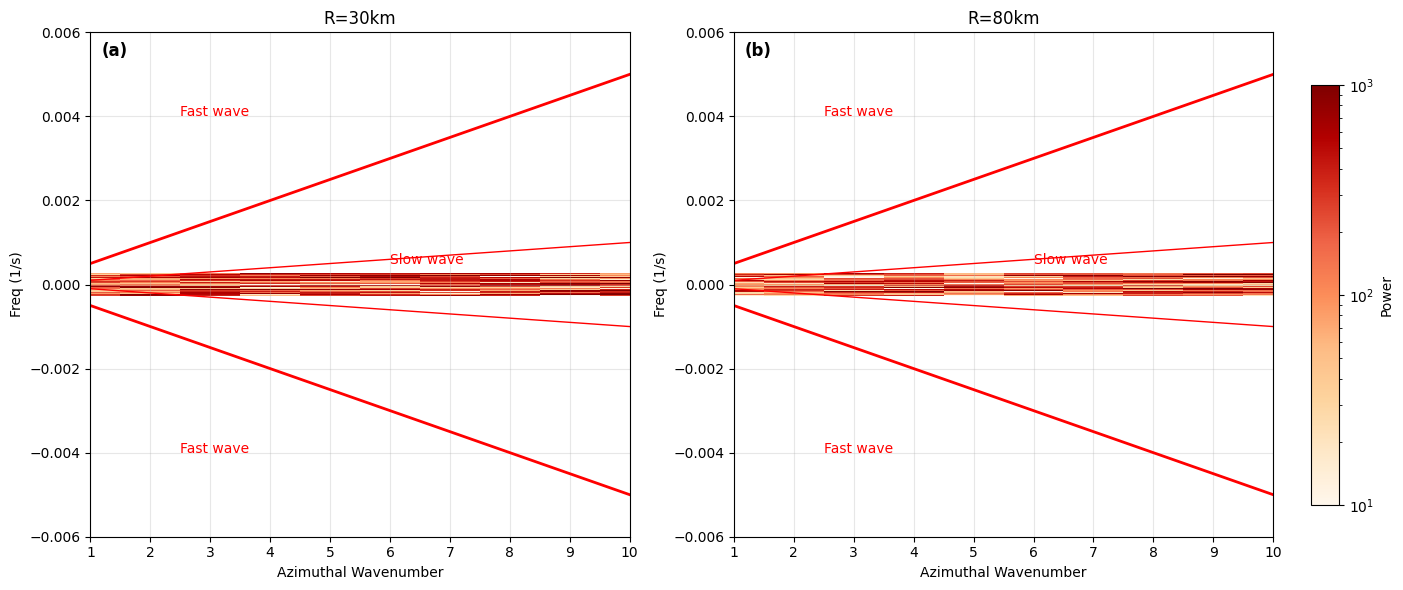

Frequency-wavenumber spectral analysis complete!


"\n# Load your GPM IMERG data\nfile_path = 'your_imerg_file.nc4'  # or .nc\nwith h5py.File(file_path, 'r') as f:\n    precip_data = f['precipitation'][:]  # shape: (time, lat, lon)\n    lats = f['lat'][:]\n    lons = f['lon'][:]\n\n# Define storm center\ncenter_lat, center_lon = 20.0, 80.0  # example coordinates\n\n# Extract data at two radii\ndata_30km, _ = extract_radial_data(precip_data, lats, lons, center_lat, center_lon, 30)\ndata_80km, _ = extract_radial_data(precip_data, lats, lons, center_lat, center_lon, 80)\n\n# Then proceed with spectral analysis as above\n"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import xarray as xr

def haversine(lat1, lon1, lat2, lon2):
    """Calculate distance between points using Haversine formula"""
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    """Calculate azimuth angle from point 1 to point 2"""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

def extract_radial_data(precip_time_series, lats, lons, center_lat, center_lon, target_radius, radius_tolerance=5):
    """
    Extract precipitation data at a specific radius from center
    
    Parameters:
    - precip_time_series: 3D array (time, lat, lon) of precipitation
    - lats, lons: 1D arrays of latitude and longitude coordinates
    - center_lat, center_lon: Center coordinates
    - target_radius: Target radius in km
    - radius_tolerance: Tolerance for radius selection in km
    """
    lon2d, lat2d = np.meshgrid(lons, lats)
    distances = haversine(center_lat, center_lon, lat2d, lon2d)
    azimuths = azimuth(center_lat, center_lon, lat2d, lon2d)
    
    # Find points within radius tolerance
    mask = np.abs(distances - target_radius) <= radius_tolerance
    
    if np.sum(mask) == 0:
        print(f"No points found within {radius_tolerance}km of {target_radius}km radius")
        return None, None
    
    # Extract data for these points
    n_times = precip_time_series.shape[0]
    valid_distances = distances[mask]
    valid_azimuths = azimuths[mask]
    
    # Create azimuthal bins (every 10 degrees)
    azimuth_bins = np.arange(0, 360, 10)
    n_azimuth = len(azimuth_bins)
    
    # Initialize output array
    radial_data = np.zeros((n_times, n_azimuth))
    
    for t in range(n_times):
        precip_slice = precip_time_series[t, :, :][mask]
        
        # Bin by azimuth
        for i, az_bin in enumerate(azimuth_bins):
            az_mask = (valid_azimuths >= az_bin) & (valid_azimuths < az_bin + 10)
            if np.any(az_mask):
                radial_data[t, i] = np.nanmean(precip_slice[az_mask])
    
    return radial_data, azimuth_bins

def compute_frequency_wavenumber_spectrum(data, dt_seconds=1800):
    """
    Compute 2D frequency-wavenumber spectrum
    
    Parameters:
    - data: 2D array (time, azimuth)
    - dt_seconds: Time step in seconds
    """
    # Remove mean and apply window
    data_processed = data - np.mean(data, axis=0, keepdims=True)
    data_processed = data_processed - np.mean(data_processed, axis=1, keepdims=True)
    
    # Apply Hanning window
    nt, naz = data_processed.shape
    time_window = np.hanning(nt)[:, None]
    azimuth_window = np.hanning(naz)[None, :]
    data_processed = data_processed * time_window * azimuth_window
    
    # 2D FFT
    fft2d = np.fft.fft2(data_processed)
    fft2d = np.fft.fftshift(fft2d)
    power = np.abs(fft2d)**2
    
    # Create frequency and wavenumber axes
    frequencies = np.fft.fftshift(np.fft.fftfreq(nt, d=dt_seconds))
    wavenumbers = np.fft.fftshift(np.fft.fftfreq(naz, d=10))  # 10 degree spacing
    
    # Convert wavenumber to integer azimuthal modes
    wavenumber_modes = np.arange(-naz//2, naz//2)
    
    return power, frequencies, wavenumber_modes

def plot_frequency_wavenumber_spectrum(power, frequencies, wavenumbers, radius, ax=None):
    """Plot frequency-wavenumber spectrum"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot only positive wavenumbers (1 to 10)
    nk_half = len(wavenumbers) // 2
    wavenums_pos = wavenumbers[nk_half+1:nk_half+11]  # wavenumbers 1-10
    power_pos = power[:, nk_half+1:nk_half+11]
    
    # Create meshgrid for plotting
    K, F = np.meshgrid(wavenums_pos, frequencies)
    
    # Plot with logarithmic color scale
    pcm = ax.pcolormesh(K, F, power_pos, 
                        norm=LogNorm(vmin=1e1, vmax=1e3), 
                        cmap='OrRd', shading='auto')
    
    # Add theoretical dispersion curves (example curves)
    k_theory = np.linspace(1, 10, 100)
    
    # Fast wave dispersion (example: linear relationship)
    fast_wave_pos = 0.0005 * k_theory
    fast_wave_neg = -0.0005 * k_theory
    
    # Slow wave dispersion (example: weaker relationship)
    slow_wave_pos = 0.0001 * k_theory
    slow_wave_neg = -0.0001 * k_theory
    
    # Plot dispersion curves
    ax.plot(k_theory, fast_wave_pos, 'r-', linewidth=2, label='Fast wave')
    ax.plot(k_theory, fast_wave_neg, 'r-', linewidth=2)
    ax.plot(k_theory, slow_wave_pos, 'r-', linewidth=1, label='Slow wave')
    ax.plot(k_theory, slow_wave_neg, 'r-', linewidth=1)
    
    # Add text labels
    ax.text(2.5, 0.004, 'Fast wave', color='red', fontsize=10)
    ax.text(6, 0.0005, 'Slow wave', color='red', fontsize=10)
    ax.text(2.5, -0.004, 'Fast wave', color='red', fontsize=10)
    
    ax.set_xlabel('Azimuthal Wavenumber')
    ax.set_ylabel('Freq (1/s)')
    ax.set_title(f'R={radius}km')
    ax.set_xlim(1, 10)
    ax.set_ylim(-0.006, 0.006)
    ax.grid(True, alpha=0.3)
    
    return pcm

# --- Main Analysis ---

# Option 1: Create synthetic data for demonstration
print("Creating synthetic data for demonstration...")
nt, naz = 240, 36  # 240 time steps (5 days at 30-min intervals), 36 azimuthal points
time_hours = np.arange(nt) * 0.5  # 30-minute intervals
azimuth_deg = np.arange(naz) * 10  # 10-degree intervals

# Create synthetic wave data
np.random.seed(42)
data_30km = np.zeros((nt, naz))
data_80km = np.zeros((nt, naz))

# Add some wave modes
for k in [2, 4, 6]:  # azimuthal wavenumbers
    for freq in [0.002, -0.003]:  # frequencies in 1/s
        phase_t = 2 * np.pi * freq * time_hours * 3600  # convert to seconds
        phase_az = 2 * np.pi * k * azimuth_deg / 360
        
        amplitude_30 = 5 * np.random.rand()
        amplitude_80 = 3 * np.random.rand()
        
        for t in range(nt):
            for az in range(naz):
                data_30km[t, az] += amplitude_30 * np.cos(phase_t[t] + phase_az[az])
                data_80km[t, az] += amplitude_80 * np.cos(phase_t[t] + phase_az[az])

# Add noise
data_30km += 0.5 * np.random.randn(nt, naz)
data_80km += 0.5 * np.random.randn(nt, naz)

# Compute spectra
print("Computing frequency-wavenumber spectra...")
power_30km, frequencies, wavenumbers = compute_frequency_wavenumber_spectrum(data_30km)
power_80km, _, _ = compute_frequency_wavenumber_spectrum(data_80km)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pcm1 = plot_frequency_wavenumber_spectrum(power_30km, frequencies, wavenumbers, 30, ax1)
pcm2 = plot_frequency_wavenumber_spectrum(power_80km, frequencies, wavenumbers, 80, ax2)

# Add subplot labels
ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')
ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top')

# Adjust layout to make space for colorbar
plt.tight_layout(rect=[0, 0, 0.93, 1])  # Leave space on the right

# Add colorbar in a new axis to the right of both subplots
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(pcm2, cax=cbar_ax, label='Power')

plt.show()
print("Frequency-wavenumber spectral analysis complete!")
# --- Optional: Real data processing ---
# If you have real GPM IMERG data, replace the synthetic data section with:
"""
# Load your GPM IMERG data
file_path = 'your_imerg_file.nc4'  # or .nc
with h5py.File(file_path, 'r') as f:
    precip_data = f['precipitation'][:]  # shape: (time, lat, lon)
    lats = f['lat'][:]
    lons = f['lon'][:]

# Define storm center
center_lat, center_lon = 20.0, 80.0  # example coordinates

# Extract data at two radii
data_30km, _ = extract_radial_data(precip_data, lats, lons, center_lat, center_lon, 30)
data_80km, _ = extract_radial_data(precip_data, lats, lons, center_lat, center_lon, 80)

# Then proceed with spectral analysis as above
"""


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Quadrant analysis function
def analyze_quadrants(conv_data, strat_data, lat, lon, center_lat, center_lon):
    """Separate rainfall into quadrants relative to depression center"""
    
    # Define quadrants
    ne_mask = (lat >= center_lat) & (lon >= center_lon)
    nw_mask = (lat >= center_lat) & (lon < center_lon)
    se_mask = (lat < center_lat) & (lon >= center_lon)
    sw_mask = (lat < center_lat) & (lon < center_lon)
    
    quadrant_data = {
        'NE': {'conv': conv_data[ne_mask].mean(), 'strat': strat_data[ne_mask].mean()},
        'NW': {'conv': conv_data[nw_mask].mean(), 'strat': strat_data[nw_mask].mean()},
        'SE': {'conv': conv_data[se_mask].mean(), 'strat': strat_data[se_mask].mean()},
        'SW': {'conv': conv_data[sw_mask].mean(), 'strat': strat_data[sw_mask].mean()}
    }
    
    return quadrant_data

# Radial profile function
def radial_profile(data, lat, lon, center_lat, center_lon, max_radius=1000):
    """Calculate radial profile from depression center"""
    
    # Calculate distance from center
    distances = np.sqrt((lat - center_lat)**2 + (lon - center_lon)**2) * 111  # km
    
    # Bin by distance
    bins = np.arange(0, max_radius, 50)  # 50 km bins
    radial_means = []
    
    for i in range(len(bins)-1):
        mask = (distances >= bins[i]) & (distances < bins[i+1])
        radial_means.append(data[mask].mean())
    
    return bins[:-1], radial_means


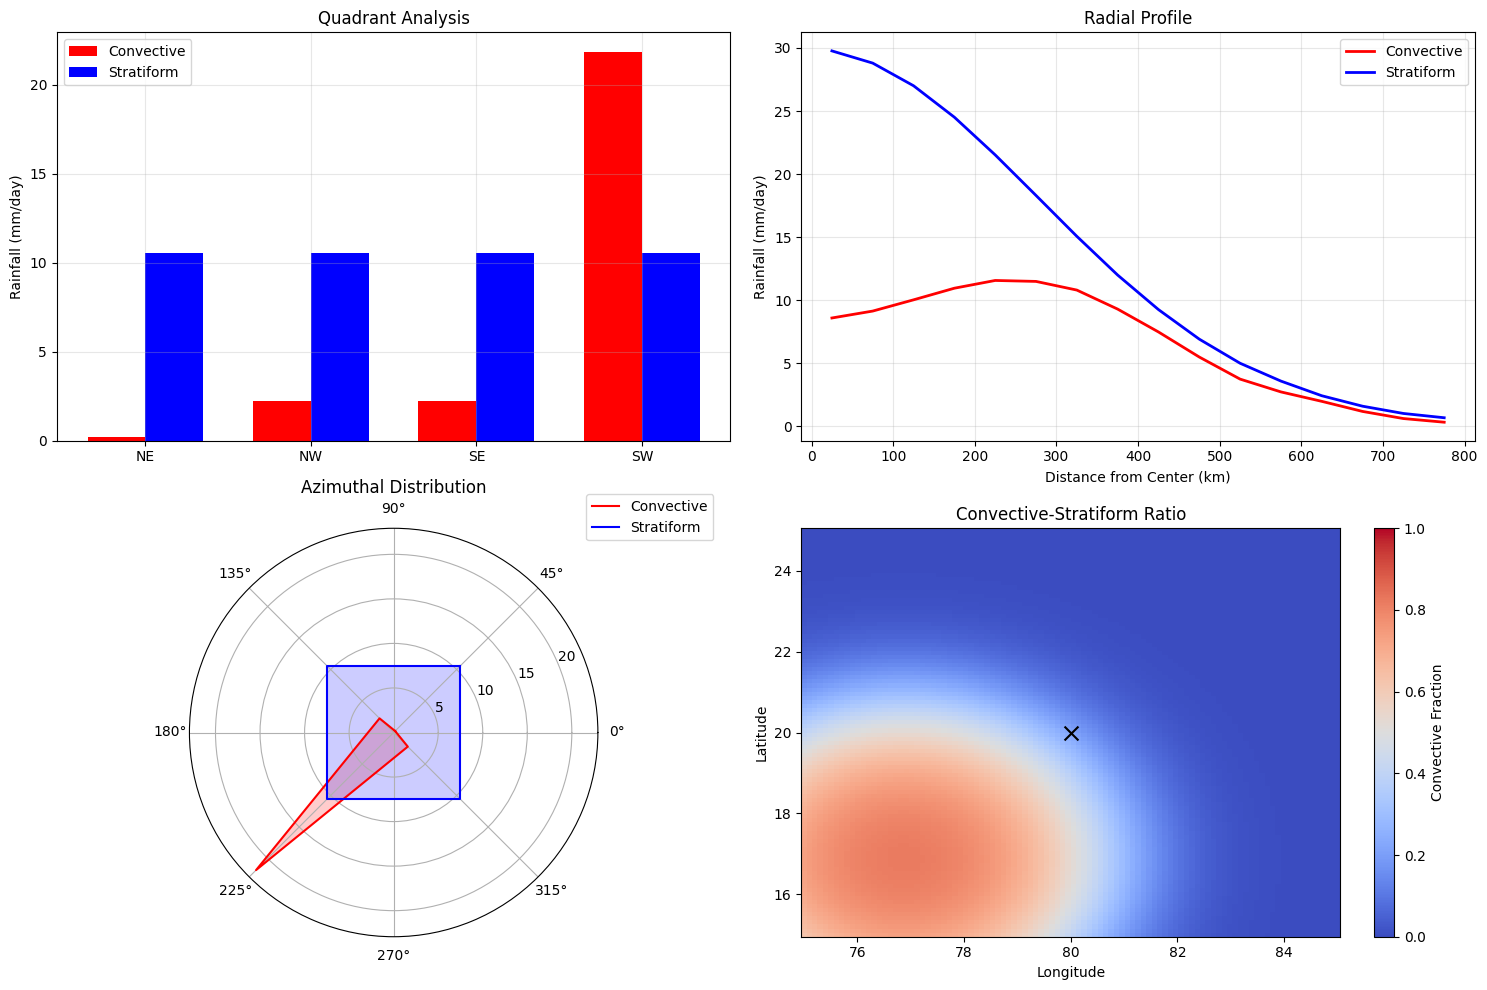

Rainfall Statistics:
Quadrant | Convective (mm/day) | Stratiform (mm/day)
NE    |               0.23 |              10.57
NW    |               2.24 |              10.57
SE    |               2.24 |              10.57
SW    |              21.84 |              10.57

Radial Peak Locations:
Convective peak: 225.0 km
Stratiform peak: 25.0 km


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data (replace with your actual data)
lat = np.linspace(15, 25, 100)  # Latitude range: 15°N to 25°N
lon = np.linspace(75, 85, 100)   # Longitude range: 75°E to 85°E
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create synthetic rainfall data (Gaussian distributions)
def gaussian2d(x, y, mx, my, sx, sy):
    return np.exp(-((x - mx)**2/(2*sx**2) + (y - my)**2/(2*sy**2)))

# Convective rainfall (stronger in SW quadrant)
conv_data = 50 * gaussian2d(lon_grid, lat_grid, 78, 18, 1.5, 1.5)

# Stratiform rainfall (broader distribution)
strat_data = 30 * gaussian2d(lon_grid, lat_grid, 80, 20, 2.5, 2.5)

# Depression center (replace with actual center)
center_lon = 80.0
center_lat = 20.0

# Quadrant analysis function
def analyze_quadrants(conv_data, strat_data, lat, lon, center_lat, center_lon):
    """Separate rainfall into quadrants relative to depression center"""
    # Define quadrants
    ne_mask = (lat >= center_lat) & (lon >= center_lon)
    nw_mask = (lat >= center_lat) & (lon < center_lon)
    se_mask = (lat < center_lat) & (lon >= center_lon)
    sw_mask = (lat < center_lat) & (lon < center_lon)
    
    quadrant_data = {
        'NE': {'conv': np.nanmean(conv_data[ne_mask]), 'strat': np.nanmean(strat_data[ne_mask])},
        'NW': {'conv': np.nanmean(conv_data[nw_mask]), 'strat': np.nanmean(strat_data[nw_mask])},
        'SE': {'conv': np.nanmean(conv_data[se_mask]), 'strat': np.nanmean(strat_data[se_mask])},
        'SW': {'conv': np.nanmean(conv_data[sw_mask]), 'strat': np.nanmean(strat_data[sw_mask])}
    }
    return quadrant_data

# Radial profile function
def radial_profile(data, lat, lon, center_lat, center_lon, max_radius=1000, bin_size=50):
    """Calculate radial profile from depression center"""
    # Calculate distance from center (in km)
    distances = np.sqrt((lat - center_lat)**2 + (lon - center_lon)**2) * 111
    bins = np.arange(0, max_radius + bin_size, bin_size)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    radial_means = []
    
    for i in range(len(bins)-1):
        mask = (distances >= bins[i]) & (distances < bins[i+1])
        if np.any(mask):
            radial_means.append(np.nanmean(data[mask]))
        else:
            radial_means.append(np.nan)
    
    return bin_centers, radial_means

# Perform analysis
quadrant_results = analyze_quadrants(conv_data, strat_data, lat_grid, lon_grid, center_lat, center_lon)
radial_bins, conv_radial = radial_profile(conv_data, lat_grid, lon_grid, center_lat, center_lon)
_, strat_radial = radial_profile(strat_data, lat_grid, lon_grid, center_lat, center_lon)

# Visualization
plt.figure(figsize=(15, 10))

# Quadrant Analysis Plot
plt.subplot(2, 2, 1)
quadrants = ['NE', 'NW', 'SE', 'SW']
conv_vals = [quadrant_results[q]['conv'] for q in quadrants]
strat_vals = [quadrant_results[q]['strat'] for q in quadrants]

x = np.arange(len(quadrants))
width = 0.35
plt.bar(x - width/2, conv_vals, width, label='Convective', color='red')
plt.bar(x + width/2, strat_vals, width, label='Stratiform', color='blue')
plt.xticks(x, quadrants)
plt.ylabel('Rainfall (mm/day)')
plt.title('Quadrant Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Radial Profile Plot
plt.subplot(2, 2, 2)
plt.plot(radial_bins, conv_radial, 'r-', label='Convective', linewidth=2)
plt.plot(radial_bins, strat_radial, 'b-', label='Stratiform', linewidth=2)
plt.xlabel('Distance from Center (km)')
plt.ylabel('Rainfall (mm/day)')
plt.title('Radial Profile')
plt.legend()
plt.grid(True, alpha=0.3)

# Azimuthal Distribution Plot
plt.subplot(2, 2, 3, projection='polar')
theta = np.deg2rad([45, 135, 225, 315])  # NE, SE, SW, NW
conv_az = [quadrant_results['NE']['conv'], quadrant_results['SE']['conv'],
           quadrant_results['SW']['conv'], quadrant_results['NW']['conv']]
strat_az = [quadrant_results['NE']['strat'], quadrant_results['SE']['strat'],
            quadrant_results['SW']['strat'], quadrant_results['NW']['strat']]

# Close the circle
theta = np.append(theta, theta[0])
conv_az = np.append(conv_az, conv_az[0])
strat_az = np.append(strat_az, strat_az[0])

plt.plot(theta, conv_az, 'r-', label='Convective')
plt.fill(theta, conv_az, 'r', alpha=0.2)
plt.plot(theta, strat_az, 'b-', label='Stratiform')
plt.fill(theta, strat_az, 'b', alpha=0.2)
plt.title('Azimuthal Distribution')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Convective-Stratiform Ratio Map
plt.subplot(2, 2, 4)
ratio = conv_data / (conv_data + strat_data + 1e-10)
plt.pcolormesh(lon, lat, ratio, cmap='coolwarm', vmin=0, vmax=1, shading='auto')
plt.colorbar(label='Convective Fraction')
plt.scatter(center_lon, center_lat, c='k', marker='x', s=100)
plt.title('Convective-Stratiform Ratio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print statistical summary
print("Rainfall Statistics:")
print(f"{'Quadrant':<5} | {'Convective (mm/day)':>18} | {'Stratiform (mm/day)':>18}")
for q in quadrants:
    print(f"{q:<5} | {quadrant_results[q]['conv']:>18.2f} | {quadrant_results[q]['strat']:>18.2f}")

print("\nRadial Peak Locations:")
print(f"Convective peak: {radial_bins[np.nanargmax(conv_radial)]:.1f} km")
print(f"Stratiform peak: {radial_bins[np.nanargmax(strat_radial)]:.1f} km")


In [6]:
def read_csv_with_guess(csv_file):
    encodings = ['utf-8', 'latin1', 'cp1252', 'utf-16']
    for enc in encodings:
        try:
            import pandas as pd
            df = pd.read_csv(csv_file, encoding=enc, low_memory=False)
            df.columns = df.columns.str.strip().str.lower()
            return df
        except Exception as e:
            last_error = str(e)
    print(f"Could not read {csv_file}: {last_error}")
    return None

center_coords = {}
for year in range(2014, 2025):
    csv_file = f'Best_T_{year}.csv'
    df = read_csv_with_guess(csv_file)
    if df is not None:
        lat_cols = [col for col in df.columns if 'latitude' in col]
        lon_cols = [col for col in df.columns if 'longitude' in col]
        if lat_cols and lon_cols:
            lat_center = df[lat_cols[0]].iloc[0]
            lon_center = df[lon_cols[0]].iloc[0]
            center_coords[year] = (lat_center, lon_center)
        else:
            print(f"Could not read {csv_file}: latitude or longitude column missing")
            center_coords[year] = (None, None)
    else:
        center_coords[year] = (None, None)


Processing 2014 (JJAS, Indian subcontinent)...
Processing 2015 (JJAS, Indian subcontinent)...
Processing 2016 (JJAS, Indian subcontinent)...
Processing 2017 (JJAS, Indian subcontinent)...
Processing 2018 (JJAS, Indian subcontinent)...
Processing 2019 (JJAS, Indian subcontinent)...
Processing 2020 (JJAS, Indian subcontinent)...
Processing 2021 (JJAS, Indian subcontinent)...
Processing 2022 (JJAS, Indian subcontinent)...
Processing 2023 (JJAS, Indian subcontinent)...
Processing 2024 (JJAS, Indian subcontinent)...


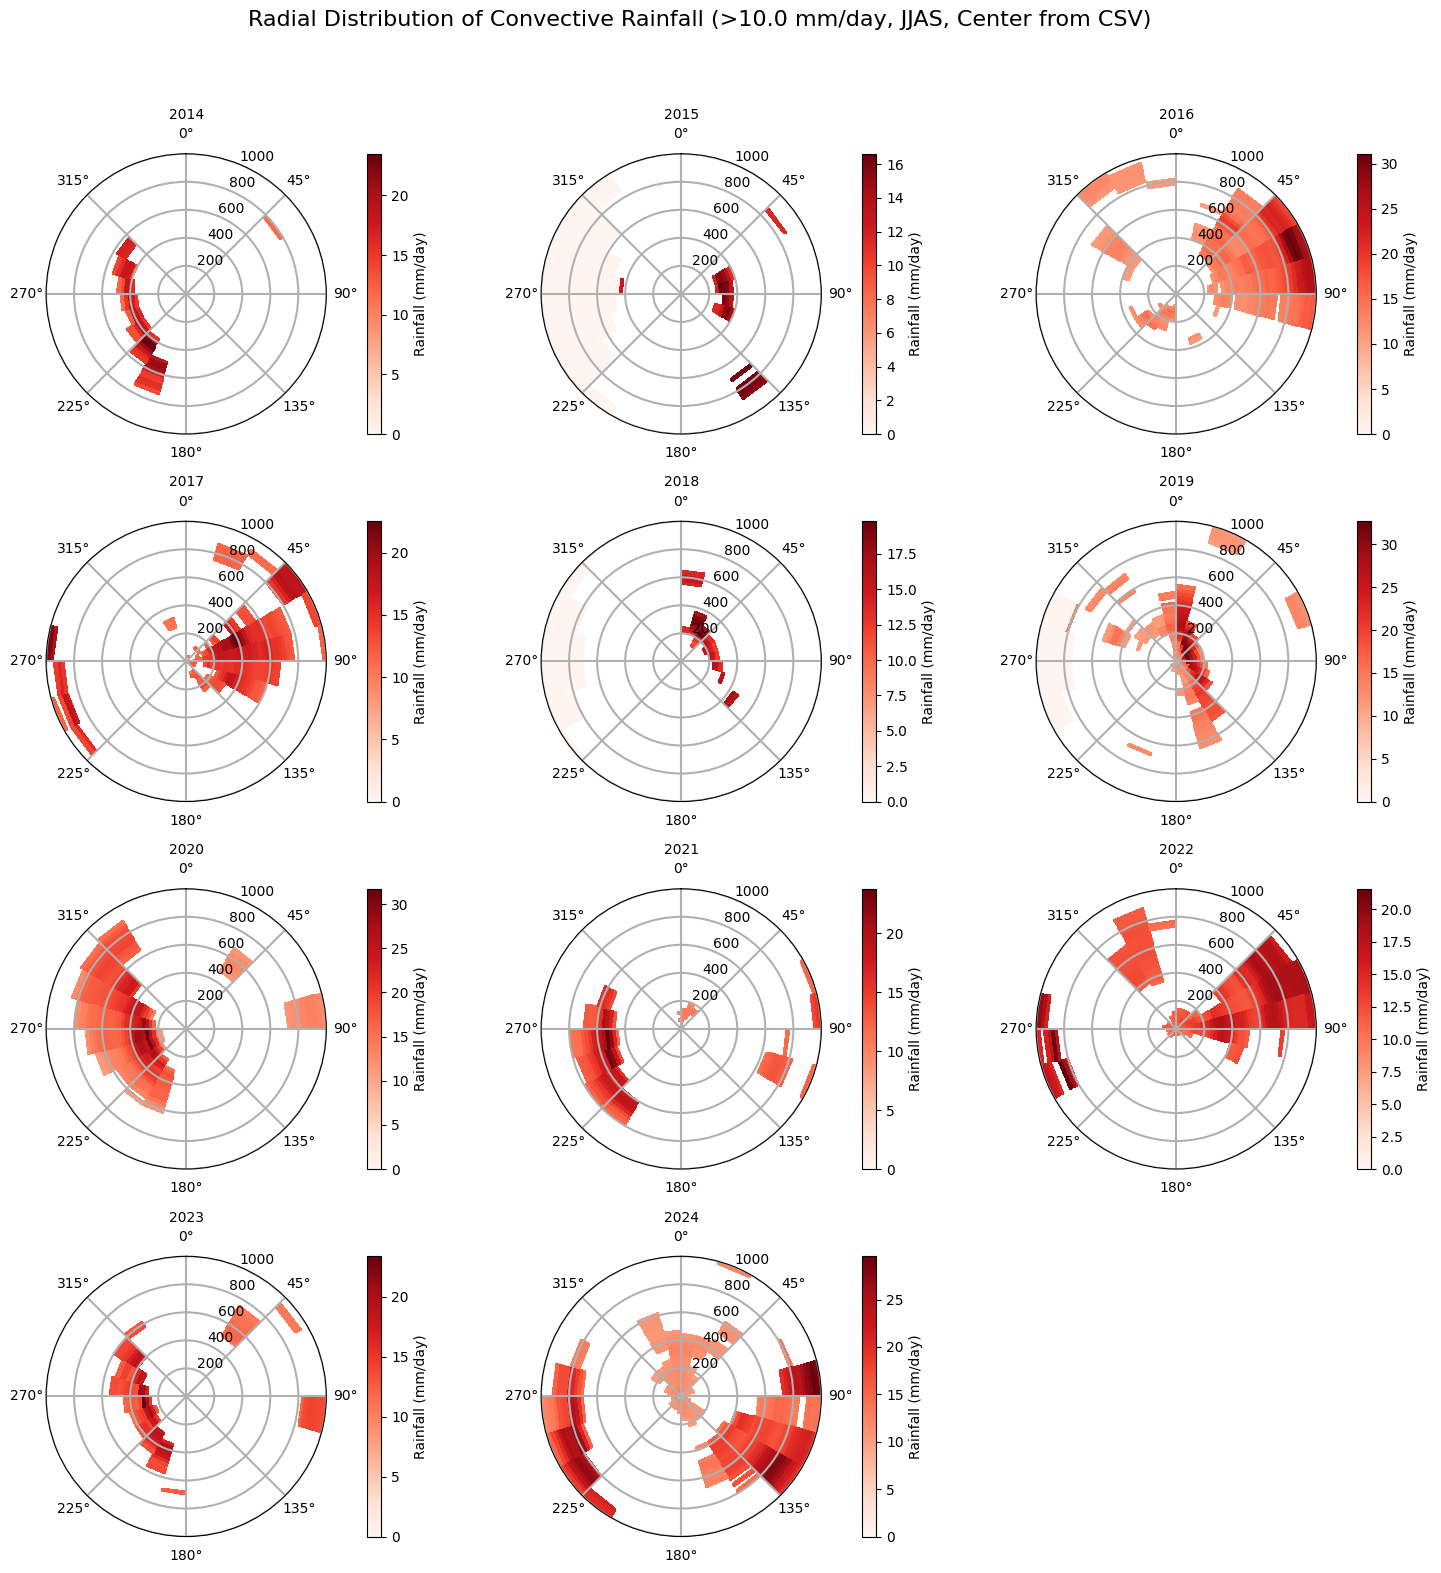

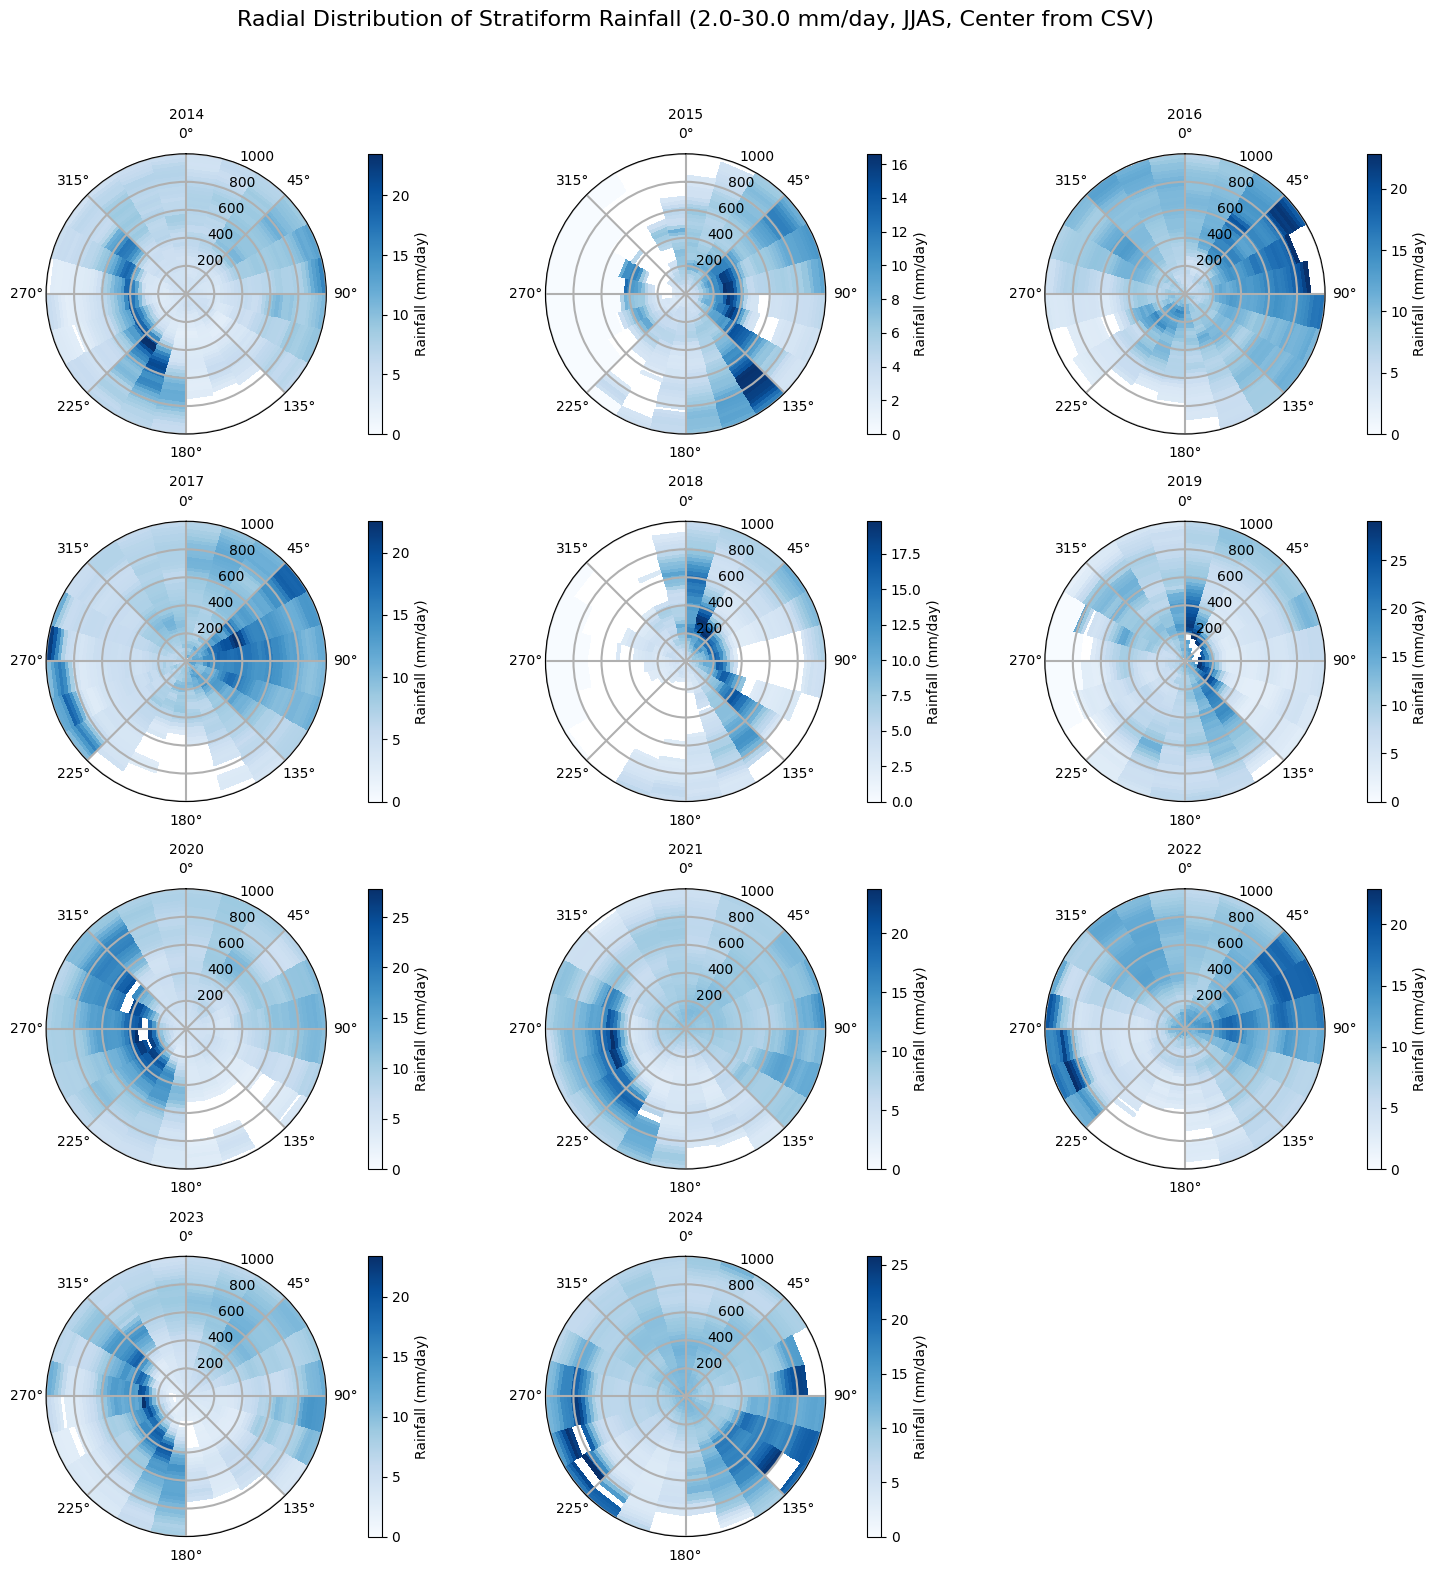

C:\Users\HONOR\AppData\Local\Temp\ipykernel_14632\3083721455.py:230: RuntimeWarning: Mean of empty slice
  azimuthal_profile = np.nanmean(results[year], axis=0)


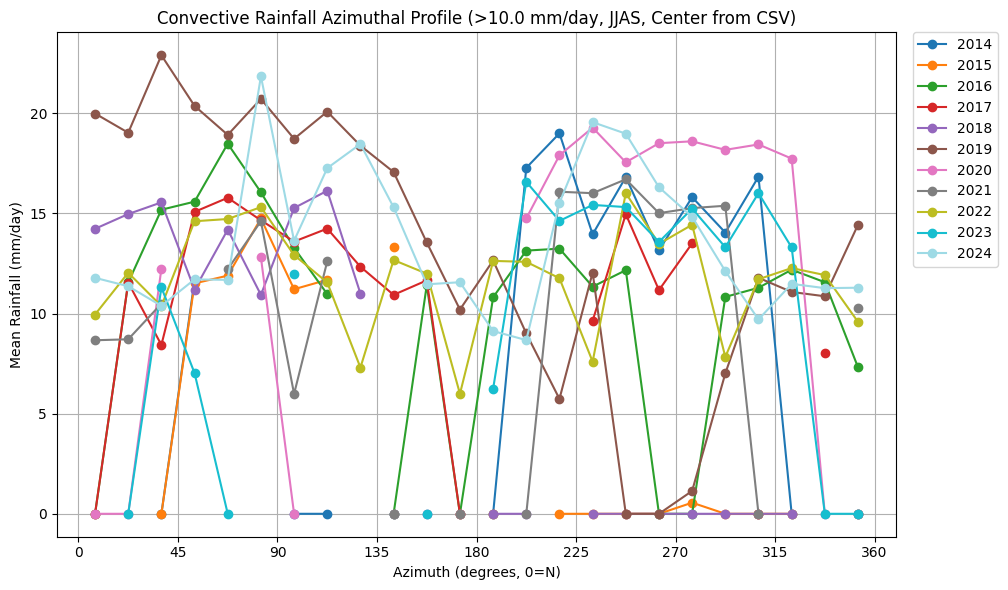

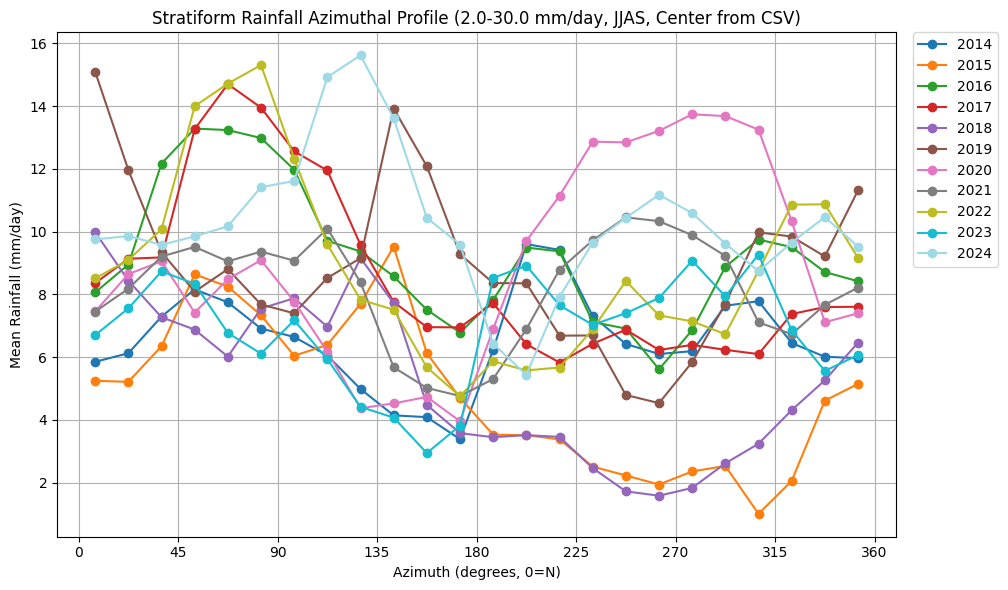

In [7]:
import os
import numpy as np
import h5py
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

years = range(2014, 2025)

# --- 1. Read center coordinates for each year from CSV ---
def read_csv_with_guess(csv_file):
    encodings = ['utf-8', 'latin1', 'cp1252', 'utf-16']
    for enc in encodings:
        try:
            df = pd.read_csv(csv_file, encoding=enc, low_memory=False)
            df.columns = df.columns.str.strip().str.lower()
            return df
        except Exception as e:
            last_error = str(e)
    print(f"Could not read {csv_file}: {last_error}")
    return None

center_coords = {}
for year in years:
    csv_file = f'Best_T_{year}.csv'
    if not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0:
        print(f"{csv_file} is missing or empty.")
        center_coords[year] = (None, None)
        continue
    df = read_csv_with_guess(csv_file)
    if df is not None and not df.empty:
        lat_cols = [col for col in df.columns if 'latitude' in col]
        lon_cols = [col for col in df.columns if 'longitude' in col]
        if lat_cols and lon_cols:
            lat_vals = pd.to_numeric(df[lat_cols[0]], errors='coerce')
            lon_vals = pd.to_numeric(df[lon_cols[0]], errors='coerce')
            lat_center = float(lat_vals.mean())
            lon_center = float(lon_vals.mean())
            if np.isnan(lat_center) or np.isnan(lon_center):
                print(f"Could not extract valid center for {year} (all values NaN)")
                center_coords[year] = (None, None)
            else:
                center_coords[year] = (lat_center, lon_center)
        else:
            print(f"Could not read {csv_file}: latitude or longitude column missing")
            center_coords[year] = (None, None)
    else:
        print(f"{csv_file} is empty or could not be read.")
        center_coords[year] = (None, None)

# --- 2. Helper functions ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

def is_jjas(filename):
    try:
        date_str = filename.split('.')[4][:8]
        month = int(date_str[4:6])
        return month in [6, 7, 8, 9]
    except Exception:
        return False

def restrict_india(precip, lats, lons):
    lat_mask = (lats >= 5) & (lats <= 37)
    lon_mask = (lons >= 66) & (lons <= 98)
    if precip.shape[0] == len(lats) and precip.shape[1] == len(lons):
        precip_sub = precip[lat_mask, :][:, lon_mask]
    elif precip.shape[1] == len(lats) and precip.shape[0] == len(lons):
        precip = precip.T
        precip_sub = precip[lat_mask, :][:, lon_mask]
    else:
        raise ValueError("Cannot determine array order for subsetting")
    lats_sub = lats[lat_mask]
    lons_sub = lons[lon_mask]
    return precip_sub, lats_sub, lons_sub

def compute_radial_azimuthal(precip, lats, lons, lat0, lon0, radial_bins, azimuthal_bins):
    lon2d, lat2d = np.meshgrid(lons, lats)
    R = haversine(lat0, lon0, lat2d, lon2d)
    Theta = azimuth(lat0, lon0, lat2d, lon2d)
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()
    precip_flat = precip.flatten()
    sum_precip, _, _ = np.histogram2d(
        R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins], weights=precip_flat
    )
    counts, _, _ = np.histogram2d(
        R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins]
    )
    return np.divide(sum_precip, counts, out=np.zeros_like(sum_precip), where=counts != 0)

# --- 3. Analysis ---
convective_threshold = 10.0  # mm/day
stratiform_lower = 2.0
stratiform_upper = 30.0

radial_bins = np.arange(0, 1000+25, 25)
azimuthal_bins = np.arange(0, 360+15, 15)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

convective_results = {}
stratiform_results = {}

for year in years:
    lat0, lon0 = center_coords.get(year, (None, None))
    if lat0 is None or lon0 is None:
        print(f"No center coordinates for {year}, skipping...")
        continue

    print(f"Processing {year} (JJAS, Indian subcontinent)...")
    if year < 2020:
        file_path = f'merge_{year}.nc'
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        with xr.open_dataset(file_path) as ds:
            var = 'precipitation' if 'precipitation' in ds else 'precipitationCal'
            ds_jjas = ds.sel(time=ds['time'].dt.month.isin([6,7,8,9]))
            if len(ds_jjas['time']) == 0:
                print(f"No JJAS data found for {year}")
                continue
            precip = ds_jjas[var].mean(dim='time').values
            lats = ds['lat'].values
            lons = ds['lon'].values
    else:
        folder_path = f'merge_{year}'
        if not os.path.isdir(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        nc4_files = sorted([
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.nc4') and is_jjas(f)
        ])
        if not nc4_files:
            print(f"No JJAS files found for {year}")
            continue
        annual_sum = None
        annual_count = None
        lats, lons = None, None
        for fpath in nc4_files:
            try:
                with h5py.File(fpath, 'r') as f:
                    daily_precip = f['precipitation'][0, :, :].astype(np.float32)
                    if annual_sum is None:
                        annual_sum = np.zeros_like(daily_precip, dtype=np.float64)
                        annual_count = np.zeros_like(daily_precip, dtype=np.uint32)
                        lats = f['lat'][:]
                        lons = f['lon'][:]
                    valid_mask = ~np.isnan(daily_precip)
                    annual_sum[valid_mask] += daily_precip[valid_mask]
                    annual_count[valid_mask] += 1
            except Exception as e:
                print(f"Skipped {os.path.basename(fpath)}: {str(e)[:50]}...")
        if annual_sum is not None and np.any(annual_count > 0):
            precip = np.divide(annual_sum, annual_count, 
                               out=np.full_like(annual_sum, np.nan), 
                               where=annual_count>0)
        else:
            print(f"No valid JJAS data for year {year}")
            continue

    # Restrict to Indian subcontinent
    try:
        precip_sub, lats_sub, lons_sub = restrict_india(precip, lats, lons)
    except Exception as e:
        print(f"Error restricting to India: {e}")
        continue

    # Mask for convective
    conv_mask = precip_sub > convective_threshold
    convective = np.where(conv_mask, precip_sub, np.nan)
    convective_results[year] = compute_radial_azimuthal(convective, lats_sub, lons_sub, lat0, lon0, radial_bins, azimuthal_bins)

    # Mask for stratiform
    strat_mask = (precip_sub >= stratiform_lower) & (precip_sub <= stratiform_upper)
    stratiform = np.where(strat_mask, precip_sub, np.nan)
    stratiform_results[year] = compute_radial_azimuthal(stratiform, lats_sub, lons_sub, lat0, lon0, radial_bins, azimuthal_bins)

# --- 4. Plotting ---
def plot_radial_distribution_per_panel(results, title, cmap='Reds'):
    valid_years = sorted(results.keys())
    n_years = len(valid_years)
    ncols = 3
    nrows = (n_years + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection': 'polar'}, figsize=(15, 4*nrows))
    axes = axes.flatten() if nrows > 1 else [axes]
    for idx, year in enumerate(valid_years):
        ax = axes[idx]
        data = results[year]
        if np.all(np.isnan(data)):
            ax.set_title(f'{year}\nNo Data', fontsize=10)
            ax.axis('off')
            continue
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        pcm = ax.pcolormesh(theta_centers, r_centers, data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f'{year}', fontsize=10)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        fig.colorbar(pcm, ax=ax, pad=0.1, fraction=0.05, label='Rainfall (mm/day)')
        ax.grid(linewidth=1.5)
    for idx in range(n_years, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_azimuthal_profiles(results, title):
    plt.figure(figsize=(12, 6))
    degrees = (azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2
    valid_years = sorted(results.keys())
    cmap = plt.get_cmap('tab20', len(valid_years))
    for i, year in enumerate(valid_years):
        azimuthal_profile = np.nanmean(results[year], axis=0)
        plt.plot(degrees, azimuthal_profile, marker='o', label=str(year), color=cmap(i))
    plt.xlabel('Azimuth (degrees, 0=N)')
    plt.ylabel('Mean Rainfall (mm/day)')
    plt.title(title)
    plt.xticks(np.arange(0, 361, 45))
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# --- Plot all ---
plot_radial_distribution_per_panel(
    convective_results,
    f'Radial Distribution of Convective Rainfall (>{convective_threshold} mm/day, JJAS, Center from CSV)',
    cmap='Reds'
)
plot_radial_distribution_per_panel(
    stratiform_results,
    f'Radial Distribution of Stratiform Rainfall ({stratiform_lower}-{stratiform_upper} mm/day, JJAS, Center from CSV)',
    cmap='Blues'
)
plot_azimuthal_profiles(
    convective_results,
    f'Convective Rainfall Azimuthal Profile (>{convective_threshold} mm/day, JJAS, Center from CSV)'
)
plot_azimuthal_profiles(
    stratiform_results,
    f'Stratiform Rainfall Azimuthal Profile ({stratiform_lower}-{stratiform_upper} mm/day, JJAS, Center from CSV)'
)


Could not extract valid center for 2014. Using default center (20, 80).
Could not extract valid center for 2015. Using default center (20, 80).
Year 2016: using center_lat=16.60, center_lon=84.69 from CSV.
Could not extract valid center for 2017. Using default center (20, 80).
Could not extract valid center for 2018. Using default center (20, 80).
Could not extract valid center for 2019. Using default center (20, 80).
Could not extract valid center for 2020. Using default center (20, 80).
Could not extract valid center for 2021. Using default center (20, 80).
Could not extract valid center for 2022. Using default center (20, 80).
Could not extract valid center for 2023. Using default center (20, 80).
Could not extract valid center for 2024. Using default center (20, 80).

Year 2014 Quadrant Stats:
Quadrant | Convective (mm/day) | Stratiform (mm/day)
NE    |               0.23 |              10.57
NW    |               2.24 |              10.57
SE    |               2.24 |              

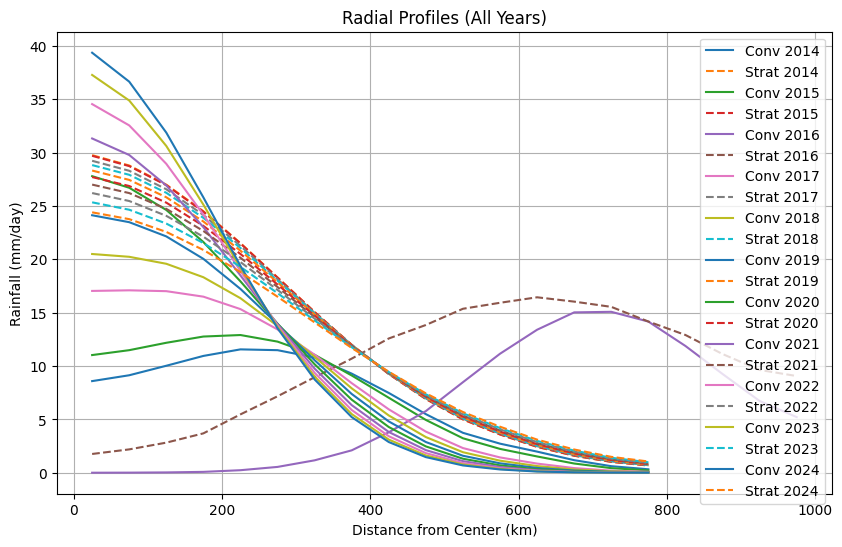

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

years = list(range(2014, 2025))

def read_csv_center(csv_file):
    encodings = ['utf-8', 'latin1', 'cp1252', 'utf-16']
    for enc in encodings:
        try:
            df = pd.read_csv(csv_file, encoding=enc, low_memory=False)
            df.columns = df.columns.str.strip()
            lat_col = [col for col in df.columns if 'lat' in col.lower()][0]
            lon_col = [col for col in df.columns if 'long' in col.lower()][0]
            lat_vals = pd.to_numeric(df[lat_col], errors='coerce')
            lon_vals = pd.to_numeric(df[lon_col], errors='coerce')
            lat_center = float(lat_vals.mean())
            lon_center = float(lon_vals.mean())
            if np.isnan(lat_center) or np.isnan(lon_center):
                return None, None
            return lat_center, lon_center
        except Exception as e:
            return None, None

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

def analyze_quadrants(conv_data, strat_data, lat, lon, center_lat, center_lon):
    ne_mask = (lat >= center_lat) & (lon >= center_lon)
    nw_mask = (lat >= center_lat) & (lon < center_lon)
    se_mask = (lat < center_lat) & (lon >= center_lon)
    sw_mask = (lat < center_lat) & (lon < center_lon)
    quadrant_data = {
        'NE': {'conv': np.nanmean(conv_data[ne_mask]), 'strat': np.nanmean(strat_data[ne_mask])},
        'NW': {'conv': np.nanmean(conv_data[nw_mask]), 'strat': np.nanmean(strat_data[nw_mask])},
        'SE': {'conv': np.nanmean(conv_data[se_mask]), 'strat': np.nanmean(strat_data[se_mask])},
        'SW': {'conv': np.nanmean(conv_data[sw_mask]), 'strat': np.nanmean(strat_data[sw_mask])}
    }
    return quadrant_data

def radial_profile(data, lat, lon, center_lat, center_lon, max_radius=1000, bin_size=50):
    distances = np.sqrt((lat - center_lat)**2 + (lon - center_lon)**2) * 111
    bins = np.arange(0, max_radius + bin_size, bin_size)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    radial_means = []
    for i in range(len(bins)-1):
        mask = (distances >= bins[i]) & (distances < bins[i+1])
        if np.any(mask):
            radial_means.append(np.nanmean(data[mask]))
        else:
            radial_means.append(np.nan)
    return bin_centers, radial_means

def get_rainfall_data(year):
    lat = np.linspace(15, 25, 100)
    lon = np.linspace(75, 85, 100)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    # Make the center of the Gaussian move with year for demonstration
    conv_center_lon = 78 + (year-2014)*0.2
    conv_center_lat = 18 + (year-2014)*0.1
    strat_center_lon = 80 - (year-2014)*0.15
    strat_center_lat = 20 - (year-2014)*0.05
    conv_data = 50 * np.exp(-((lon_grid - conv_center_lon)**2/(2*1.5**2) + (lat_grid - conv_center_lat)**2/(2*1.5**2)))
    strat_data = 30 * np.exp(-((lon_grid - strat_center_lon)**2/(2*2.5**2) + (lat_grid - strat_center_lat)**2/(2*2.5**2)))
    return lat, lon, lat_grid, lon_grid, conv_data, strat_data


all_quadrant_results = {}
all_radial_profiles = {}

for year in years:
    csv_file = f'Best_T_{year}.csv'
    center_lat, center_lon = None, None
    if os.path.exists(csv_file) and os.path.getsize(csv_file) > 0:
        center_lat, center_lon = read_csv_center(csv_file)
        if center_lat is not None and center_lon is not None:
            print(f"Year {year}: using center_lat={center_lat:.2f}, center_lon={center_lon:.2f} from CSV.")
        else:
            print(f"Could not extract valid center for {year}. Using default center (20, 80).")
            center_lat, center_lon = 20.0, 80.0
    else:
        print(f"{csv_file} is missing or empty. Using default center (20, 80) for year {year}.")
        center_lat, center_lon = 20.0, 80.0
    lat, lon, lat_grid, lon_grid, conv_data, strat_data = get_rainfall_data(year)
    quadrant_results = analyze_quadrants(conv_data, strat_data, lat_grid, lon_grid, center_lat, center_lon)
    radial_bins, conv_radial = radial_profile(conv_data, lat_grid, lon_grid, center_lat, center_lon)
    _, strat_radial = radial_profile(strat_data, lat_grid, lon_grid, center_lat, center_lon)
    all_quadrant_results[year] = quadrant_results
    all_radial_profiles[year] = {'conv': conv_radial, 'strat': strat_radial, 'bins': radial_bins}

# Print quadrant stats for all years
for year in all_quadrant_results:
    print(f"\nYear {year} Quadrant Stats:")
    quadrants = ['NE', 'NW', 'SE', 'SW']
    print(f"{'Quadrant':<5} | {'Convective (mm/day)':>18} | {'Stratiform (mm/day)':>18}")
    for q in quadrants:
        print(f"{q:<5} | {all_quadrant_results[year][q]['conv']:>18.2f} | {all_quadrant_results[year][q]['strat']:>18.2f}")

# Plot radial profiles for all years
plt.figure(figsize=(10, 6))
for year in all_radial_profiles:
    bins = all_radial_profiles[year]['bins']
    plt.plot(bins, all_radial_profiles[year]['conv'], label=f'Conv {year}')
    plt.plot(bins, all_radial_profiles[year]['strat'], '--', label=f'Strat {year}')
plt.xlabel('Distance from Center (km)')
plt.ylabel('Rainfall (mm/day)')
plt.title('Radial Profiles (All Years)')
plt.legend()
plt.grid(True)
plt.show()


Could not extract valid center for 2014. Using default center (20, 80).
Could not extract valid center for 2015. Using default center (20, 80).
Year 2016: using center_lat=16.60, center_lon=84.69 from CSV.
Could not extract valid center for 2017. Using default center (20, 80).
Could not extract valid center for 2018. Using default center (20, 80).
Could not extract valid center for 2019. Using default center (20, 80).
Could not extract valid center for 2020. Using default center (20, 80).
Could not extract valid center for 2021. Using default center (20, 80).
Could not extract valid center for 2022. Using default center (20, 80).
Could not extract valid center for 2023. Using default center (20, 80).
Could not extract valid center for 2024. Using default center (20, 80).


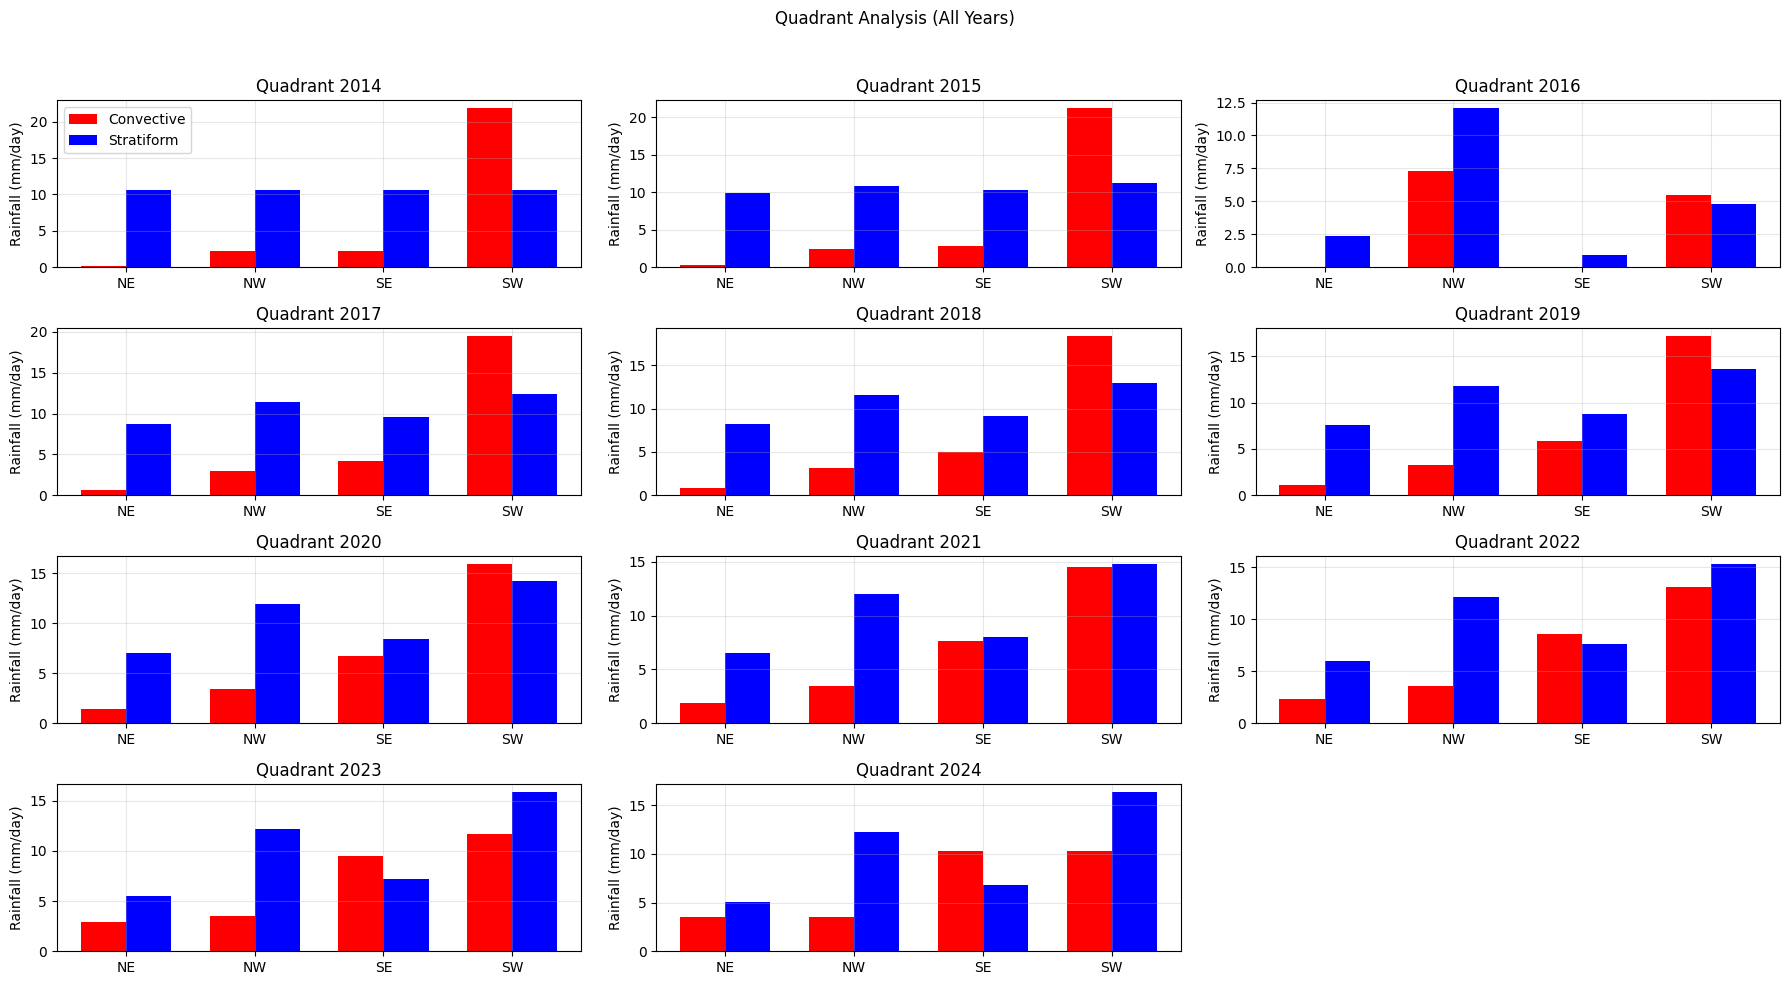

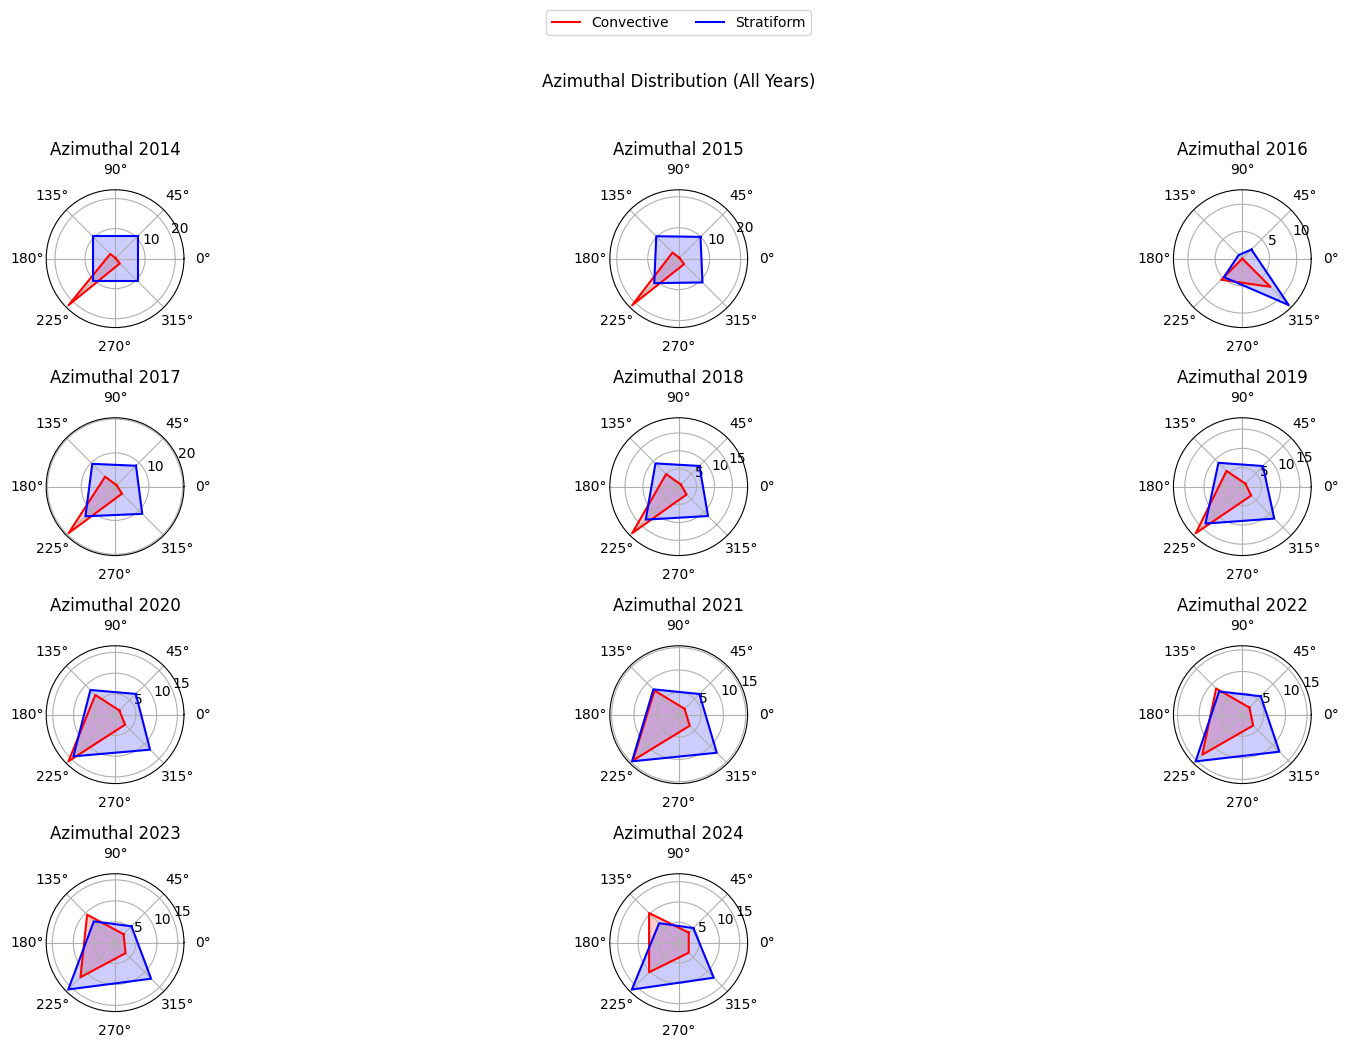

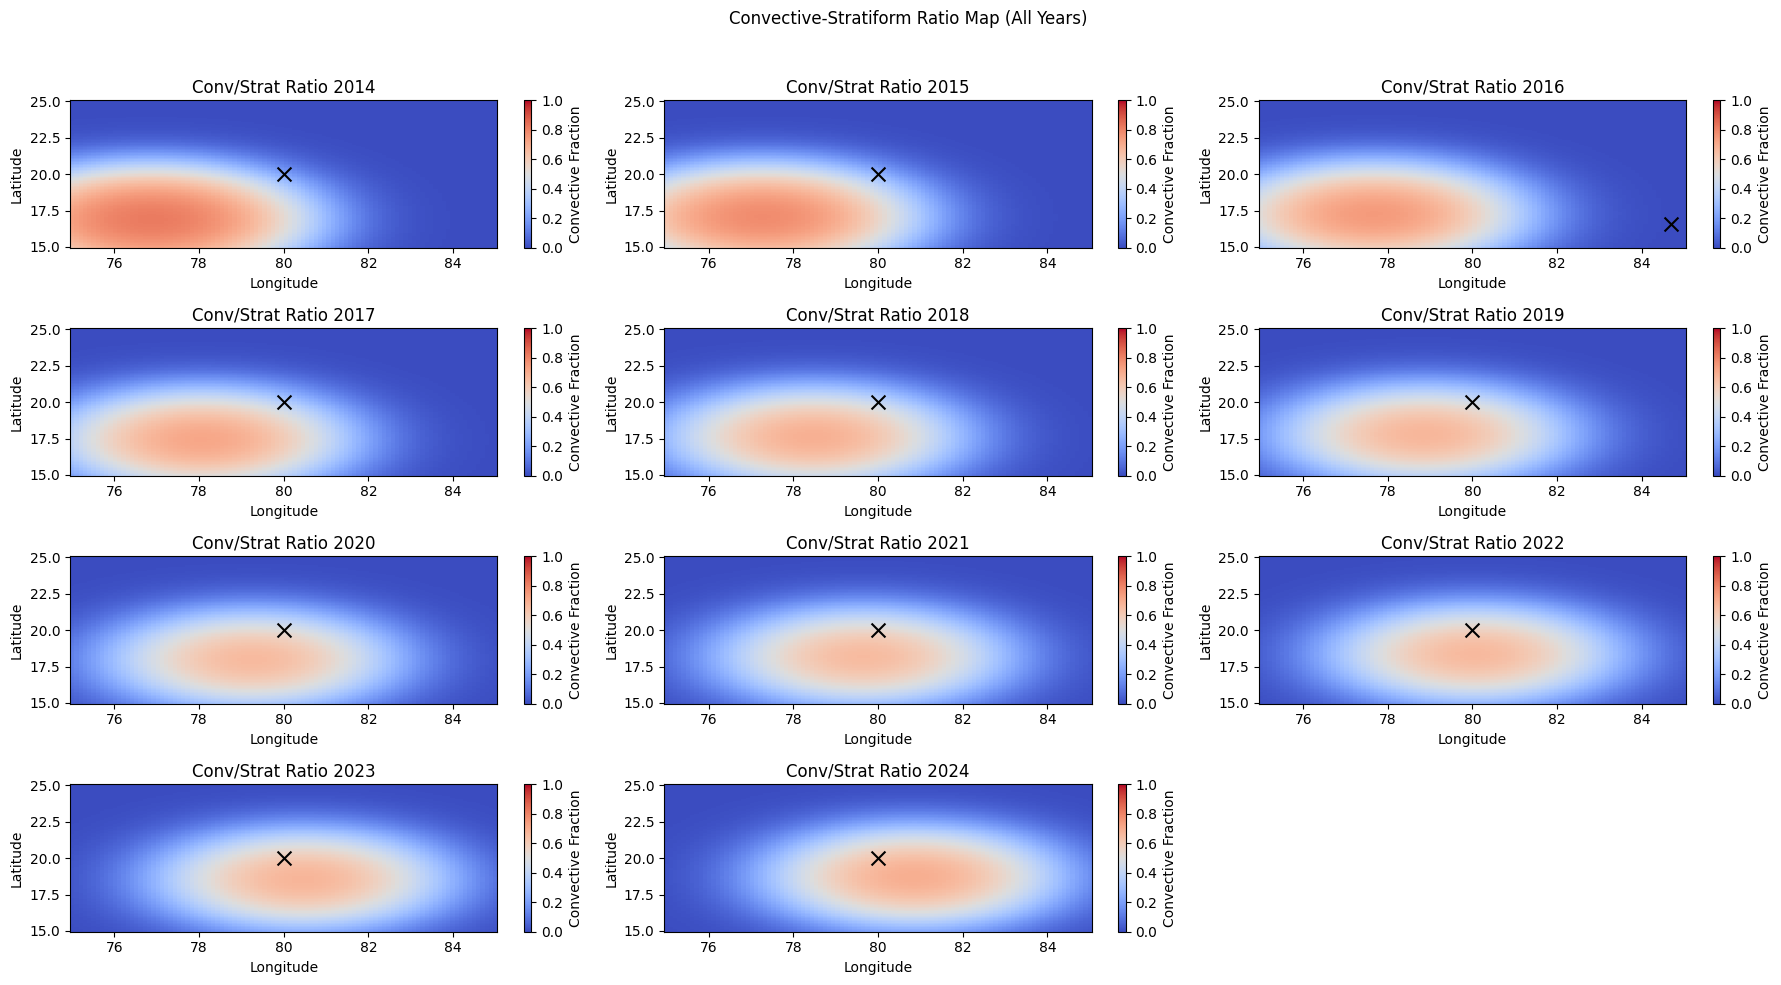

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

years = list(range(2014, 2025))

def read_csv_center(csv_file):
    encodings = ['utf-8', 'latin1', 'cp1252', 'utf-16']
    for enc in encodings:
        try:
            df = pd.read_csv(csv_file, encoding=enc, low_memory=False)
            df.columns = df.columns.str.strip()
            lat_col = [col for col in df.columns if 'lat' in col.lower()][0]
            lon_col = [col for col in df.columns if 'long' in col.lower()][0]
            lat_vals = pd.to_numeric(df[lat_col], errors='coerce')
            lon_vals = pd.to_numeric(df[lon_col], errors='coerce')
            lat_center = float(lat_vals.mean())
            lon_center = float(lon_vals.mean())
            if np.isnan(lat_center) or np.isnan(lon_center):
                return None, None
            return lat_center, lon_center
        except Exception as e:
            return None, None

def get_rainfall_data(year):
    lat = np.linspace(15, 25, 100)
    lon = np.linspace(75, 85, 100)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    # Make the center of the Gaussian move with year for demonstration
    conv_center_lon = 78 + (year-2014)*0.2
    conv_center_lat = 18 + (year-2014)*0.1
    strat_center_lon = 80 - (year-2014)*0.15
    strat_center_lat = 20 - (year-2014)*0.05
    conv_data = 50 * np.exp(-((lon_grid - conv_center_lon)**2/(2*1.5**2) + (lat_grid - conv_center_lat)**2/(2*1.5**2)))
    strat_data = 30 * np.exp(-((lon_grid - strat_center_lon)**2/(2*2.5**2) + (lat_grid - strat_center_lat)**2/(2*2.5**2)))
    return lat, lon, lat_grid, lon_grid, conv_data, strat_data

def analyze_quadrants(conv_data, strat_data, lat, lon, center_lat, center_lon):
    ne_mask = (lat >= center_lat) & (lon >= center_lon)
    nw_mask = (lat >= center_lat) & (lon < center_lon)
    se_mask = (lat < center_lat) & (lon >= center_lon)
    sw_mask = (lat < center_lat) & (lon < center_lon)
    quadrant_data = {
        'NE': {'conv': np.nanmean(conv_data[ne_mask]), 'strat': np.nanmean(strat_data[ne_mask])},
        'NW': {'conv': np.nanmean(conv_data[nw_mask]), 'strat': np.nanmean(strat_data[nw_mask])},
        'SE': {'conv': np.nanmean(conv_data[se_mask]), 'strat': np.nanmean(strat_data[se_mask])},
        'SW': {'conv': np.nanmean(conv_data[sw_mask]), 'strat': np.nanmean(strat_data[sw_mask])}
    }
    return quadrant_data

# --- Storage ---
all_quadrant_results = {}
all_azimuthal_results = {}
all_ratio_maps = {}

for year in years:
    csv_file = f'Best_T_{year}.csv'
    center_lat, center_lon = None, None
    if os.path.exists(csv_file) and os.path.getsize(csv_file) > 0:
        center_lat, center_lon = read_csv_center(csv_file)
        if center_lat is not None and center_lon is not None:
            print(f"Year {year}: using center_lat={center_lat:.2f}, center_lon={center_lon:.2f} from CSV.")
        else:
            print(f"Could not extract valid center for {year}. Using default center (20, 80).")
            center_lat, center_lon = 20.0, 80.0
    else:
        print(f"{csv_file} is missing or empty. Using default center (20, 80) for year {year}.")
        center_lat, center_lon = 20.0, 80.0

    lat, lon, lat_grid, lon_grid, conv_data, strat_data = get_rainfall_data(year)
    quadrant_results = analyze_quadrants(conv_data, strat_data, lat_grid, lon_grid, center_lat, center_lon)
    all_quadrant_results[year] = quadrant_results

    # For azimuthal plot: order is NE, SE, SW, NW, NE (to close the circle)
    quadrants = ['NE', 'SE', 'SW', 'NW', 'NE']
    conv_az = [quadrant_results[q]['conv'] for q in quadrants]
    strat_az = [quadrant_results[q]['strat'] for q in quadrants]
    all_azimuthal_results[year] = {'conv': conv_az, 'strat': strat_az}

    # For ratio map
    ratio = conv_data / (conv_data + strat_data + 1e-10)
    all_ratio_maps[year] = {'ratio': ratio, 'lat': lat, 'lon': lon, 'center_lat': center_lat, 'center_lon': center_lon}

# --- 1. Quadrant Analysis Bar Plot ---
plt.figure(figsize=(18, 10))
ncols = 3
nrows = int(np.ceil(len(years) / ncols))
for idx, year in enumerate(years):
    plt.subplot(nrows, ncols, idx+1)
    quadrants = ['NE', 'NW', 'SE', 'SW']
    if year in all_quadrant_results:
        conv_vals = [all_quadrant_results[year][q]['conv'] for q in quadrants]
        strat_vals = [all_quadrant_results[year][q]['strat'] for q in quadrants]
        x = np.arange(len(quadrants))
        width = 0.35
        plt.bar(x - width/2, conv_vals, width, label='Convective', color='red')
        plt.bar(x + width/2, strat_vals, width, label='Stratiform', color='blue')
        plt.xticks(x, quadrants)
        plt.ylabel('Rainfall (mm/day)')
        plt.title(f'Quadrant {year}')
        plt.grid(True, alpha=0.3)
    if idx == 0:
        plt.legend()
plt.suptitle('Quadrant Analysis (All Years)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig = plt.figure(figsize=(18, 10))
axes = []
for idx, year in enumerate(years):
    ax = plt.subplot(nrows, ncols, idx+1, projection='polar')
    axes.append(ax)
    if year in all_azimuthal_results:
        theta = np.deg2rad([45, 135, 225, 315, 45])  # NE, SE, SW, NW, NE
        conv_plot, = ax.plot(theta, all_azimuthal_results[year]['conv'], 'r-', label='Convective')
        ax.fill(theta, all_azimuthal_results[year]['conv'], 'r', alpha=0.2)
        strat_plot, = ax.plot(theta, all_azimuthal_results[year]['strat'], 'b-', label='Stratiform')
        ax.fill(theta, all_azimuthal_results[year]['strat'], 'b', alpha=0.2)
        ax.set_title(f'Azimuthal {year}')
# Only add legend once, outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.suptitle('Azimuthal Distribution (All Years)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- 3. Convective-Stratiform Ratio Map ---
plt.figure(figsize=(18, 10))
for idx, year in enumerate(years):
    plt.subplot(nrows, ncols, idx+1)
    if year in all_ratio_maps:
        ratio = all_ratio_maps[year]['ratio']
        lat = all_ratio_maps[year]['lat']
        lon = all_ratio_maps[year]['lon']
        center_lat = all_ratio_maps[year]['center_lat']
        center_lon = all_ratio_maps[year]['center_lon']
        plt.pcolormesh(lon, lat, ratio, cmap='coolwarm', vmin=0, vmax=1, shading='auto')
        plt.colorbar(label='Convective Fraction')
        plt.scatter(center_lon, center_lat, c='k', marker='x', s=100)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Conv/Strat Ratio {year}')
plt.suptitle('Convective-Stratiform Ratio Map (All Years)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [1]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# import h5py

# def read_csv_center(csv_file):
#     encodings = ['utf-8', 'latin1', 'cp1252', 'utf-16']
#     for enc in encodings:
#         try:
#             df = pd.read_csv(csv_file, encoding=enc, low_memory=False)
#             df.columns = df.columns.str.strip()
#             lat_col = [col for col in df.columns if 'latitude' in col.lower()][0]
#             lon_col = [col for col in df.columns if 'long' in col.lower()][0]
#             lat_vals = pd.to_numeric(df[lat_col], errors='coerce')
#             lon_vals = pd.to_numeric(df[lon_col], errors='coerce')
#             lat_center = float(lat_vals.mean())
#             lon_center = float(lon_vals.mean())
#             if np.isnan(lat_center) or np.isnan(lon_center):
#                 return None, None
#             return lat_center, lon_center
#         except Exception as e:
#             print(f"Could not extract center from {csv_file} with encoding {enc}: {e}")
#     print(f"Could not extract center from {csv_file}: all encodings failed.")
#     return None, None

# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371.0
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     return R * c

# def azimuth(lat1, lon1, lat2, lon2):
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#     dlon = lon2 - lon1
#     x = np.sin(dlon) * np.cos(lat2)
#     y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
#     theta = np.arctan2(x, y)
#     return (np.degrees(theta) + 360) % 360

# def extract_radial_data(precip_time_series, lats, lons, center_lat, center_lon, target_radius, radius_tolerance=5):
#     lon2d, lat2d = np.meshgrid(lons, lats)
#     distances = haversine(center_lat, center_lon, lat2d, lon2d)
#     azimuths = azimuth(center_lat, center_lon, lat2d, lon2d)
#     mask = np.abs(distances - target_radius) <= radius_tolerance
#     if np.sum(mask) == 0:
#         print(f"No points found within {radius_tolerance}km of {target_radius}km radius")
#         return None, None
#     n_times = precip_time_series.shape[0]
#     valid_azimuths = azimuths[mask]
#     azimuth_bins = np.arange(0, 360, 10)
#     n_azimuth = len(azimuth_bins)
#     radial_data = np.zeros((n_times, n_azimuth))
#     for t in range(n_times):
#         precip_slice = precip_time_series[t, :, :].T  # Transpose to (lat, lon)
#         for i, az_bin in enumerate(azimuth_bins):
#             az_mask = (valid_azimuths >= az_bin) & (valid_azimuths < az_bin + 10)
#             if np.any(az_mask):
#                 radial_data[t, i] = np.nanmean(precip_slice[mask][az_mask])
#             else:
#                 radial_data[t, i] = np.nan
#     return radial_data, azimuth_bins

# def compute_frequency_wavenumber_spectrum(data, dt_seconds=1800):
#     data_processed = data - np.nanmean(data, axis=0, keepdims=True)
#     data_processed = data_processed - np.nanmean(data_processed, axis=1, keepdims=True)
#     nt, naz = data_processed.shape
#     time_window = np.hanning(nt)[:, None]
#     azimuth_window = np.hanning(naz)[None, :]
#     data_processed = data_processed * time_window * azimuth_window
#     fft2d = np.fft.fft2(data_processed)
#     fft2d = np.fft.fftshift(fft2d)
#     power = np.abs(fft2d)**2
#     frequencies = np.fft.fftshift(np.fft.fftfreq(nt, d=dt_seconds))
#     wavenumbers = np.fft.fftshift(np.fft.fftfreq(naz, d=10))
#     wavenumber_modes = np.arange(-naz//2, naz//2)
#     return power, frequencies, wavenumber_modes

# def plot_frequency_wavenumber_spectrum(power, frequencies, wavenumbers, radius, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(8, 6))
#     nk_half = len(wavenumbers) // 2
#     wavenums_pos = wavenumbers[nk_half+1:nk_half+11]
#     power_pos = power[:, nk_half+1:nk_half+11]
#     K, F = np.meshgrid(wavenums_pos, frequencies)
#     pcm = ax.pcolormesh(K, F, power_pos, norm=LogNorm(vmin=1e1, vmax=1e3), cmap='OrRd', shading='auto')
#     k_theory = np.linspace(1, 10, 100)
#     fast_wave_pos = 0.0005 * k_theory
#     fast_wave_neg = -0.0005 * k_theory
#     slow_wave_pos = 0.0001 * k_theory
#     slow_wave_neg = -0.0001 * k_theory
#     ax.plot(k_theory, fast_wave_pos, 'r-', linewidth=2, label='Fast wave')
#     ax.plot(k_theory, fast_wave_neg, 'r-', linewidth=2)
#     ax.plot(k_theory, slow_wave_pos, 'r-', linewidth=1, label='Slow wave')
#     ax.plot(k_theory, slow_wave_neg, 'r-', linewidth=1)
#     ax.text(2.5, 0.004, 'Fast wave', color='red', fontsize=10)
#     ax.text(6, 0.0005, 'Slow wave', color='red', fontsize=10)
#     ax.text(2.5, -0.004, 'Fast wave', color='red', fontsize=10)
#     ax.set_xlabel('Azimuthal Wavenumber')
#     ax.set_ylabel('Freq (1/s)')
#     ax.set_title(f'R={radius} km')
#     ax.set_xlim(1, 10)
#     ax.set_ylim(-0.006, 0.006)
#     ax.grid(True, alpha=0.3)
#     return pcm

# # ---- LOOP OVER YEARS ----

# # For shape harmonization
# nt_list_30km = []
# nt_list_80km = []
# temp_power_30km = {}
# temp_power_80km = {}
# temp_freq_30km = {}
# temp_freq_80km = {}
# temp_wnum_30km = {}
# temp_wnum_80km = {}

# for year in range(2014, 2025):
#     csv_file = f'Best_T_{year}.csv'
#     center_lat, center_lon = read_csv_center(csv_file)
#     if center_lat is None or center_lon is None:
#         center_lat, center_lon = 20.0, 80.0  # fallback
#     print(f"Year {year}: Using center: lat={center_lat:.2f}, lon={center_lon:.2f}")

#     if year < 2020:
#         imerg_file = f'merge_{year}.nc'
#         try:
#             with h5py.File(imerg_file, 'r') as f:
#                 if 'precipitationCal' in f:
#                     precip_data = f['precipitationCal'][:]  # (time, lat, lon)
#                 elif 'precipitation' in f:
#                     precip_data = f['precipitation'][:]
#                 else:
#                     raise ValueError("No precipitation variable found in file!")
#                 lats = f['lat'][:]
#                 lons = f['lon'][:]
#         except Exception as e:
#             print(f"Could not open {imerg_file}: {e}")
#             continue
#     else:
#         folder_path = f'merge_{year}'
#         if not os.path.isdir(folder_path):
#             print(f"Folder not found: {folder_path}")
#             continue
#         nc4_files = sorted([
#             os.path.join(folder_path, f)
#             for f in os.listdir(folder_path)
#             if f.endswith('.nc4')
#         ])
#         if not nc4_files:
#             print(f"No .nc4 files found for {year}")
#             continue
#         precip_list = []
#         for fpath in nc4_files:
#             try:
#                 with h5py.File(fpath, 'r') as f:
#                     if 'precipitation' in f:
#                         daily_precip = f['precipitation'][:]
#                     elif 'precipitationCal' in f:
#                         daily_precip = f['precipitationCal'][:]
#                     else:
#                         continue
#                     precip_list.append(daily_precip)
#                     if 'lat' in f and 'lon' in f:
#                         lats = f['lat'][:]
#                         lons = f['lon'][:]
#             except Exception as e:
#                 print(f"Skipped {os.path.basename(fpath)}: {str(e)[:50]}...")
#         if not precip_list:
#             print(f"No valid precipitation data for {year}")
#             continue
#         precip_data = np.stack(precip_list, axis=0)  # shape: (time, lat, lon)

#     # 3. Extract data at two radii
#     data_30km, _ = extract_radial_data(precip_data, lats, lons, center_lat, center_lon, 30)
#     data_80km, _ = extract_radial_data(precip_data, lats, lons, center_lat, center_lon, 80)

#     if data_30km is None or data_80km is None:
#         print(f"Skipping year {year} due to missing data at desired radii.")
#         continue

#     # 4. Compute spectra
#     power_30km, frequencies_30km, wavenumbers_30km = compute_frequency_wavenumber_spectrum(data_30km)
#     power_80km, frequencies_80km, wavenumbers_80km = compute_frequency_wavenumber_spectrum(data_80km)

#     # Store for shape check and later averaging
#     temp_power_30km[year] = power_30km
#     temp_power_80km[year] = power_80km
#     temp_freq_30km[year] = frequencies_30km
#     temp_freq_80km[year] = frequencies_80km
#     temp_wnum_30km[year] = wavenumbers_30km
#     temp_wnum_80km[year] = wavenumbers_80km
#     nt_list_30km.append(power_30km.shape[0])
#     nt_list_80km.append(power_80km.shape[0])

# # After loop: harmonize shapes and average
# if len(nt_list_30km) == 0 or len(nt_list_80km) == 0:
#     print("No valid years found for averaging.")
# else:
#     nt_min_30km = min(nt_list_30km)
#     nt_min_80km = min(nt_list_80km)
#     sum_power_30km = None
#     sum_power_80km = None
#     count_years = 0

#     # Use frequencies and wavenumbers from the first available year
#     for year in temp_power_30km:
#         p30 = temp_power_30km[year][:nt_min_30km, :]
#         p80 = temp_power_80km[year][:nt_min_80km, :]
#         if sum_power_30km is None:
#             sum_power_30km = p30.copy()
#             sum_power_80km = p80.copy()
#             frequencies_30km = temp_freq_30km[year][:nt_min_30km]
#             frequencies_80km = temp_freq_80km[year][:nt_min_80km]
#             wavenumbers_30km = temp_wnum_30km[year]
#             wavenumbers_80km = temp_wnum_80km[year]
#         else:
#             sum_power_30km += p30
#             sum_power_80km += p80
#         count_years += 1

#     avg_power_30km = sum_power_30km / count_years
#     avg_power_80km = sum_power_80km / count_years

#     # Plot average mean
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
#     pcm1 = plot_frequency_wavenumber_spectrum(avg_power_30km, frequencies_30km, wavenumbers_30km, 30, ax1)
#     pcm2 = plot_frequency_wavenumber_spectrum(avg_power_80km, frequencies_80km, wavenumbers_80km, 80, ax2)
#     ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')
#     ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top')
#     fig.suptitle(f"Average Frequency–Wavenumber Spectrum of Rainfall\nR=30 km and R=80 km from Depression Centers (2014–2024)", fontsize=16)
#     plt.tight_layout(rect=[0, 0, 0.93, 0.95])
#     cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
#     fig.colorbar(pcm2, cax=cbar_ax, label='Power')
#     plt.show()
